# Social Graphs and Interactions Project - Group 35

## Data Preprocessing & Network Setup

In [45]:
# Installing necessary libraries 
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install networkx
!pip install powerlaw
!pip install graphistry
!pip install cpi
!pip install nltk
!pip install scipy

In [2]:
# Importing necessary libraries
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw
import seaborn as sns
import graphistry
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from scipy import stats
import cpi
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import chain
from community import community_louvain
import math

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

C:\Users\mahs2\AppData\Local\Temp\ipykernel_72664\3135320842.py:13: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  import cpi
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mahs2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahs2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data & initialize graph nodes

The following code block loads the Boxofficemojo dataset, removes movies where there is no worldwide box office data, convert runtime to integers, converts release date to "xx-xx-xxxx" format and initializes the graph nodes  

In [3]:
movies = pd.read_csv(r'data\Kaggle\Mojo_budget_update.csv\Mojo_budget_update.csv')
# remove a column mpaa
movies = movies.drop(columns=['mpaa'])
# remove rows with nan in worldwide and in budget
movies = movies.dropna(subset=["worldwide"])
# movies = movies.dropna(subset=["budget"])
# fill nan with unknown
movies = movies.fillna("UNKNOWN",)

#Make a graph
movie_graph = nx.Graph()
movie_graph.add_nodes_from(movies['title'])

# reformat the date
def getDate(year,date):
    dict_months = {'January':"1", 'February':"2", 'March':"3", 'April':"4", 'May':"5", 'June':"6", 'July':"7", 'August':"8", 'September':"9", 'October':"10", 'November':"11", 'December':"12"}
    try:
        date = date.split()
    except:
        date = ['January','1']
    year = str(year)
    date = str(date[1]) + '-' + dict_months[date[0]] + '-' + year
    return date

# reformat the run time
def getRunTime(run_time):
    try:
        run_time = run_time.split()
        run_time = int(run_time[0]) * 60 + int(run_time[2])
    except:
        run_time = "UNKNOWN"
    return run_time

# add attributes to the nodes
for node in movie_graph.nodes:
    row = movies.loc[movies['title'] == node]
    movie_id, _,release_year,_,release_date, run_time, distributor, director, writer, producer, composer, cinematographer, \
    main_actor_1, main_actor_2, main_actor_3, main_actor_4, budget, domestic, international, worldwide, \
    genre_1, genre_2, genre_3, genre_4, link = row.iloc[0, :].values

    release_date = getDate(release_year, release_date)
    run_time = getRunTime(run_time)
    actors = [main_actor_1, main_actor_2, main_actor_3, main_actor_4]
    genres = [genre_1, genre_2, genre_3, genre_4]
    
    movie_graph.nodes[node]['movie_id'] = movie_id
    movie_graph.nodes[node]['release_year'] = release_year
    movie_graph.nodes[node]['release_date'] = release_date
    movie_graph.nodes[node]['run_time'] = run_time
    movie_graph.nodes[node]['distributor'] = distributor
    movie_graph.nodes[node]['director'] = director
    movie_graph.nodes[node]['writer'] = writer
    movie_graph.nodes[node]['producer'] = producer
    movie_graph.nodes[node]['composer'] = composer
    movie_graph.nodes[node]['cinematographer'] = cinematographer
    movie_graph.nodes[node]['actors'] = actors
    movie_graph.nodes[node]['budget'] = budget
    movie_graph.nodes[node]['domestic'] = domestic
    movie_graph.nodes[node]['international'] = international
    movie_graph.nodes[node]['worldwide'] = worldwide
    movie_graph.nodes[node]['genres'] = genres
    movie_graph.nodes[node]['link'] = link


In [4]:
# Print information about the movie network

print("Number of nodes", len(movie_graph.nodes)) 
print("Number of unique distributor", len(movies["distributor"].unique()))
# print("percentage of movies per distributor" , movies["distributor"].value_counts())
print(f"Budget Stats \n mean is {round(movies["budget"].mean())}, midian is {movies["budget"].median()}, standard deviation budget is { round(movies["budget"].std())}")
print(f"worldwide Stats \n mean is {round(movies["worldwide"].mean())}, midian is {movies['worldwide'].median()}, standard deviation worldwide is { round(movies['worldwide'].std())}")
print("Number of unique genres", len(movies["genre_1"].unique()))
print("Number of unique actors", len((movies["main_actor_1"]+movies["main_actor_2"]+movies["main_actor_3"]+movies["main_actor_4"]).unique()))
print(f"Number of unique directors {len(movies['director'].unique())} writers {len(movies['writer'].unique())} and producers {len(movies['producer'].unique())} and composers {len(movies['composer'].unique())} and cinematographers {len(movies['cinematographer'].unique())}")
print(f"Earnings Stats \n mean is {round(movies['worldwide'].mean())-round(movies['budget'].mean())}, midian is {movies['worldwide'].median()-movies['budget'].median()}")
print("biggest Winner is ", movies.loc[(movies['worldwide']-movies['budget']).idxmax()]['title'])
print("biggest Loser is ", movies.loc[(movies['worldwide']-movies['budget']).idxmin()]['title'])

Number of nodes 3208
Number of unique distributor 197
Budget Stats 
 mean is 46308759, midian is 30000000.0, standard deviation budget is 47097816
worldwide Stats 
 mean is 139312154, midian is 62251587.5, standard deviation worldwide is 216210703
Number of unique genres 15
Number of unique actors 3212
Number of unique directors 1520 writers 2103 and producers 1539 and composers 792 and cinematographers 854
Earnings Stats 
 mean is 93003395, midian is 32251587.5
biggest Winner is  Avatar
biggest Loser is  Mars Needs Moms


In [5]:
movies[movies['title'] == 'The Matrix']

movie_id       title  year  \
464  tt0133093  The Matrix  1999   

                                                trivia release_date  \
464  A computer hacker learns from mysterious rebel...     March 31   

        run_time   distributor        director           writer     producer  \
464  2 hr 16 min  Warner Bros.  Lana Wachowski  Lilly Wachowski  Joel Silver   

     ...  main_actor_4      budget     domestic international    worldwide  \
464  ...  Hugo Weaving  63000000.0  171479930.0   293863857.0  465343787.0   

    genre_1  genre_2  genre_3  genre_4  \
464  Action   Sci-Fi  UNKNOWN  UNKNOWN   

                                                  html  
464  https://www.boxofficemojo.com/title/tt0133093/...  

[1 rows x 25 columns]

The following code block does:
* Reads the Rotten Tomatoes reviews dataset
* keeps the movie id, reviewid, and review text
* drop rows that holds no review text
* Reads the Rotten Tomatoes movies dataset (where it  holds information about the movies)
* Joins the 2 data sets into a `merged_reviews` data sets that now holds id, reviewId, reviewText and movie title

In [6]:
reviews = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movie_reviews.csv')
reviews_head = reviews.head()
reviews=reviews[["id","reviewId","reviewText"]]
reviews = reviews.dropna(subset=["reviewText"])
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')
RT_movies=RT_movies[["id","title","tomatoMeter"]]
merged_reviews = pd.merge(RT_movies, reviews, on='id')
merged_reviews = pd.merge(merged_reviews, movies[['title']], left_on='title', right_on='title')

In [7]:
print("number of movies with reviews", len(merged_reviews['title'].unique()))
print("number of reviews", len(merged_reviews['reviewId'].unique()))
print("number of reviews per movie", merged_reviews['title'].value_counts(ascending=False))
print(f"mean number of reviews per movie {merged_reviews['title'].value_counts().mean()} median {merged_reviews['title'].value_counts().median()}")
print("number of movies with more than 50 reviews", len(merged_reviews['title'].value_counts()[merged_reviews['title'].value_counts()>50]))
print(f"The mean length of reviews is {merged_reviews['reviewText'].apply(len).mean()} and the median is {merged_reviews['reviewText'].apply(len).median()}")
print(f"The mean number of words in reviews is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).mean()} and the median is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).median()}")

number of movies with reviews 2932
number of reviews 413562
number of reviews per movie title
Parasite                  1921
Beauty and the Beast      1168
The Lion King             1122
Godzilla                  1084
Little Women              1038
                          ... 
A Long Way Off               1
The Lorax                    1
Royal Kill                   1
Beat the Drum                1
Midget Zombie Takeover       1
Name: count, Length: 2932, dtype: int64
mean number of reviews per movie 146.55388813096863 median 130.0
number of movies with more than 50 reviews 2448
The mean length of reviews is 127.99440301980935 and the median is 127.0
The mean number of words in reviews is 21.466581024724455 and the median is 21.0


### Add the reviews of the movies in nodes

In [8]:
dicReviews = {}
for index, row in merged_reviews.iterrows():
    if row['title'] in movie_graph.nodes:
        if row['title'] not in dicReviews:
            dicReviews[row['title']] = []
        dicReviews[row['title']].append(row['reviewText'])
print("Number of movies with reviews", len(dicReviews))
print("total number of reviews", len([j for i in dicReviews.values() for j in i]))

for node in movie_graph.nodes:
    if node in dicReviews:
        movie_graph.nodes[node]['reviews'] = dicReviews[node]
        movie_graph.nodes[node]['tomatoMeter'] =merged_reviews.loc[merged_reviews['title'] == node]['tomatoMeter'].values[0] 

Number of movies with reviews 2932
total number of reviews 429696


In [9]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 3208


### Remove movies with no reviews

In [10]:
nodes_to_remove = []

# Find nodes without the "reviews" attributes
for node in movie_graph.nodes:
    if movie_graph.nodes[node].get("reviews") is None:
        nodes_to_remove.append(node)

# Remove those nodes from the graph
movie_graph.remove_nodes_from(nodes_to_remove)

In [11]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 2932


### Adjust the monetary values for inflation

In [12]:
##  Values to adjust : budget, domestic, international, worldwide 
for node in movie_graph.nodes:
    movie_graph.nodes[node]['budget'] = cpi.inflate(int(movie_graph.nodes[node]['budget']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['domestic'] != "UNKNOWN":
        movie_graph.nodes[node]['domestic'] = cpi.inflate(int(movie_graph.nodes[node]['domestic']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['international'] != "UNKNOWN":
        movie_graph.nodes[node]['international'] = cpi.inflate(int(movie_graph.nodes[node]['international']), movie_graph.nodes[node]['release_year'])
    movie_graph.nodes[node]['profit'] = movie_graph.nodes[node]['worldwide'] - movie_graph.nodes[node]['budget']

### Calculate the sentiment of nodes

In [13]:
# Create an instance of the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# get sentiment for each review in each node
for node in movie_graph.nodes:
    reviews = movie_graph.nodes[node]['reviews']

    sentiments_per_review = [analyzer.polarity_scores(review) for review in reviews]
    
    # movie's sentiment based on all reviews (mean compound score)          
    compound_sentiments = [sentiment_scores["compound"] for sentiment_scores in sentiments_per_review]
    movie_sentiment = np.mean(compound_sentiments) if compound_sentiments else 0.0
    
    # Assign the aggregated sentiment to the node
    movie_graph.nodes[node]['mean_compound_sentiment'] = movie_sentiment
    movie_graph.nodes[node]['sentiments_per_review'] = sentiments_per_review

In [14]:
for node in list(movie_graph.nodes)[:5]:
    print(f"- Movie : {node}")
    print(f"- Mean Compound Sentiment : {movie_graph.nodes[node]["mean_compound_sentiment"]}")
    print(f"- Rotten Tomatoes score : {movie_graph.nodes[node]["tomatoMeter"]}", "\n")


- Movie : Back to the Future Part III
- Mean Compound Sentiment : 0.4589757575757576
- Rotten Tomatoes score : 80.0 

- Movie : The Bonfire of the Vanities
- Mean Compound Sentiment : -0.07092222222222222
- Rotten Tomatoes score : 15.0 

- Movie : Dick Tracy
- Mean Compound Sentiment : 0.1416142857142857
- Rotten Tomatoes score : nan 

- Movie : Die Hard 2
- Mean Compound Sentiment : 0.10247884615384614
- Rotten Tomatoes score : 70.0 

- Movie : Flight of the Intruder
- Mean Compound Sentiment : 0.02735
- Rotten Tomatoes score : 25.0 



#### Sentiment of Movies using VADER 

We compute the sentiment of each movie directly from its text reviews using the **VADER** sentiment analyzer:

1. For every review, we compute the VADER **compound** score (between -1 and 1).
2. For each movie, we take the **average compound score** over all of its reviews.
3. This average becomes the movie's sentiment. We do **not** apply any additional shrinkage or prior-based correction.

This makes the pipeline simple and transparent: movie sentiment is just "what the reviews say on average".


##### Global Sentiment (Simple Average)

We compute a simple **global sentiment** of the network:

- Take the average VADER compound score across all movies.
- This acts as a descriptive baseline (are movies overall more positive or negative?).


In [15]:
# Compute simple global sentiment and per-movie review statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure each movie node has avg_sentiment and review_count based on VADER results
movie_sentiment_records = []

for node in movie_graph.nodes:
    # Each node already has 'reviews' and we previously computed 'mean_compound_sentiment'
    avg_sentiment = movie_graph.nodes[node].get("mean_compound_sentiment", 0.0)
    reviews = movie_graph.nodes[node].get("reviews", [])
    review_count = len(reviews)
    
    # Compute per-movie sentiment standard deviation for robustness
    sentiments_per_review = movie_graph.nodes[node].get("sentiments_per_review", None)
    if sentiments_per_review is not None and len(sentiments_per_review) > 1:
        compound_vals = [s["compound"] for s in sentiments_per_review]
        sentiment_std = float(np.std(compound_vals))
    else:
        sentiment_std = 0.0
    
    # For backward compatibility, keep an 'avg_sentiment' attribute equal to the VADER mean
    movie_graph.nodes[node]["avg_sentiment"] = avg_sentiment
    
    movie_sentiment_records.append({
        "movie": node,
        "avg_sentiment": avg_sentiment,
        "review_count": review_count,
        "sentiment_std": sentiment_std,
    })

movie_sentiment_df = pd.DataFrame(movie_sentiment_records)

# Simple global sentiment (average over movies)
global_sentiment = movie_sentiment_df["avg_sentiment"].mean()
print(f"Global average movie sentiment: {global_sentiment:.4f}")


Global average movie sentiment (VADER mean, no Bayesian adjustment): 0.1788


##### Sentiment Robustness and Review Counts

Rather than mathematically "shrinking" each movie toward a prior, we assess **how stable** a movie's sentiment is:

- Movies with **few reviews** tend to have more volatile sentiment (high standard deviation).
- Movies with **many reviews** have more stable averages.

We therefore compute, for each movie:

- `avg_sentiment`: mean VADER compound score.
- `review_count`: number of reviews.
- `sentiment_std`: standard deviation of review sentiments.

We then inspect how `sentiment_std` changes with `review_count` to judge robustness.

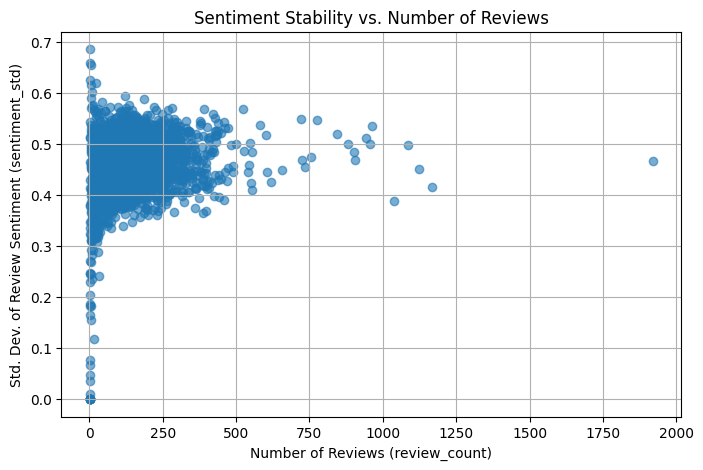

In [16]:
# Robustness check: sentiment stability versus review count

plt.figure(figsize=(8, 5))
plt.scatter(movie_sentiment_df["review_count"], movie_sentiment_df["sentiment_std"], alpha=0.6)
plt.xlabel("Number of Reviews (review_count)")
plt.ylabel("Std. Dev. of Review Sentiment (sentiment_std)")
plt.title("Sentiment Stability vs. Number of Reviews")
plt.grid(True)
plt.show()


##### Sentiment Pipeline Overview

Our final sentiment pipeline is:

1. VADER compound per review.
2. Average sentiment per movie.
3. Global average sentiment over all movies.
4. Robustness check: plot sentiment variance versus review count.

This pipeline keeps the sentiment analysis simple and easy to interpret.


### Add edges to the graph 
Two movie nodes have an edge between them if there is at least one common actor between the two movies 

In [19]:
# list of movies for each actor
actor_to_movies = defaultdict(set)

for movie in movie_graph.nodes:
    actors = movie_graph.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)


In [20]:
# Add edges between movies that share an actor
for actor, movies in actor_to_movies.items():
    movie_list = list(movies)
    for i in range(len(movie_list)):
        for j in range(i + 1, len(movie_list)):
            movie_graph.add_edge(movie_list[i], movie_list[j], actor=actor)

In [21]:
print(f"Number of nodes: {movie_graph.number_of_nodes()}")
print(f"Number of edges: {movie_graph.number_of_edges()}")

Number of nodes: 2932
Number of edges: 37774


### Delete isolated nodes

In [22]:
# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(movie_graph.degree()).items() if degree == 0]

graph_no_isolated = movie_graph.copy()
graph_no_isolated.remove_nodes_from(isolated_nodes)

### Extract the largest connected component

In [23]:
# Extract the largest connected component
graph = graph_no_isolated
largest_component = max(nx.connected_components(graph), key=len)
graph_largest = graph.subgraph(largest_component).copy()

In [24]:
print(f"Initial network number of nodes: {movie_graph.number_of_nodes()}")
print(f"Initial network edges: {movie_graph.number_of_edges()}")

print(f"\nNetwork number of nodes after excluding isolated nodes: {graph.number_of_nodes()}")
print(f"Network number of edges after excluding isolated nodes: {graph.number_of_edges()}")

print(f"\nNumber of nodes in largest_component: {graph_largest.number_of_nodes()}")
print(f"Number of edges in largest_component: {graph_largest.number_of_edges()}")

Initial network number of nodes: 2932
Initial network edges: 37774

Network number of nodes after excluding isolated nodes: 2799
Network number of edges after excluding isolated nodes: 37774

Number of nodes in largest_component: 2777
Number of edges in largest_component: 37758


# Network analysis

### Degree distribution

In [25]:
# Get degree distribution
degree_sequence = sorted([d for n, d in graph_largest.degree()], reverse=True)  # Sorted list of degrees
degree_count = np.bincount(degree_sequence)  # Count occurrences of each degree
degrees = np.arange(len(degree_count)) 

# Check for hubs in the network
max_degree = max(degree_sequence)
average_degree = np.mean(degree_sequence)
print("Maximum degree:", max_degree)
print("Average degree:", average_degree)

Maximum degree: 91
Average degree: 27.193374144760533


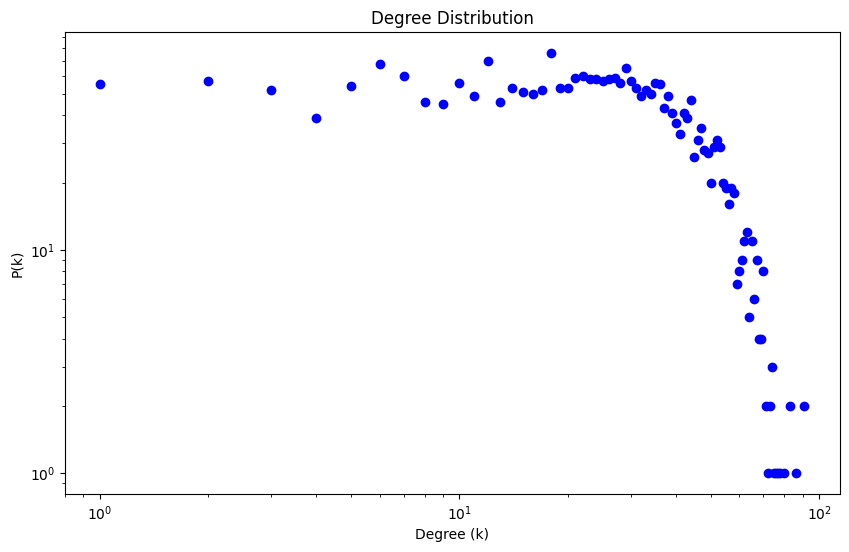

In [26]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution")
plt.show()

In [27]:
degree_sequence_sorted = sorted(degree_sequence, reverse=True)
px = [(degree_sequence_sorted.count(d))/graph_largest.number_of_nodes() for d in degree_sequence_sorted]

log_degree = np.log(degree_sequence_sorted)
log_pk = np.log(px)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_degree,log_pk)
print(f"Slope: {slope:.5f} Intercept: {intercept:.5f} R^2: {r_value**2:.5f} P-value: {p_value:.5f}")

Slope: -0.25871 Intercept: -3.35039 R^2: 0.20514 P-value: 0.00000


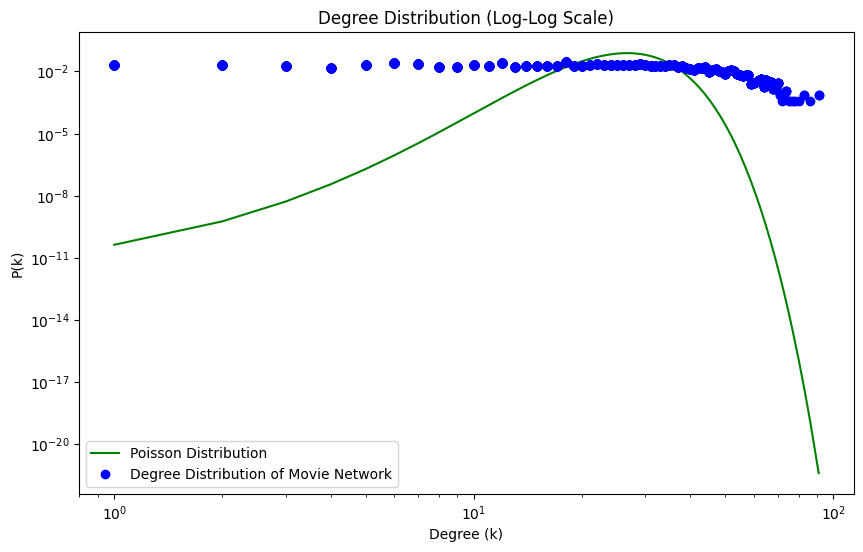

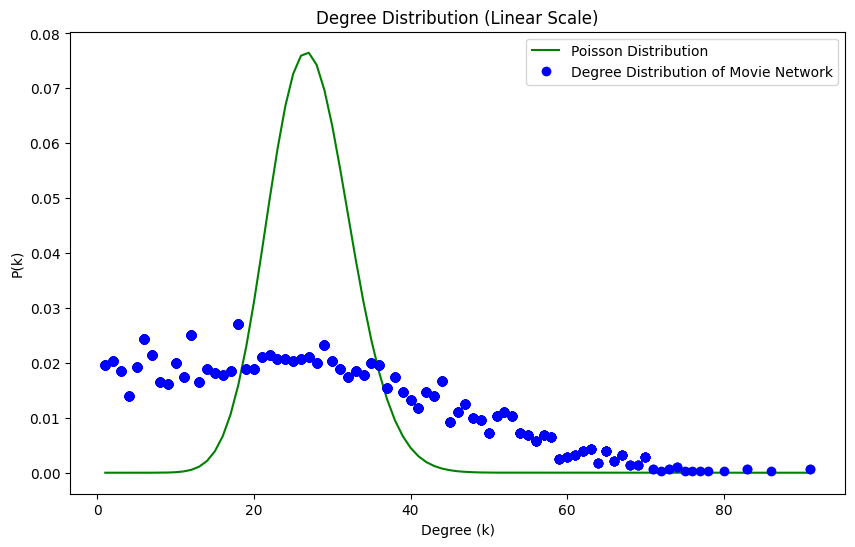

Slope: -0.25871 Intercept: -3.35039 R^2: 0.20514 P-value: 0.00000
3.295836866004329 -3.8594800456097342


In [28]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
# plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.loglog(degree_sequence,[math.exp(-average_degree) * (average_degree**d/math.factorial(d)) for d in degree_sequence] , 'g-')  
plt.loglog(degree_sequence_sorted,px, 'bo') 
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.legend(["Poisson Distribution", "Degree Distribution of Movie Network"])
plt.show()


# Plot the degree distribution on a linear scale
plt.figure(figsize=(10, 6))
plt.plot(degree_sequence, [math.exp(-average_degree) * (average_degree**d/math.factorial(d)) for d in degree_sequence] , 'g-')  # Exclude zero degree entries
plt.plot(degree_sequence_sorted, [degree_sequence.count(d)/graph_no_isolated.number_of_nodes() for d in degree_sequence], 'bo')  
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution (Linear Scale)")
plt.legend(["Poisson Distribution", "Degree Distribution of Movie Network"])
plt.show()

# linear regression
log_degree = np.log(degree_sequence_sorted)
log_pk = np.log(px)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_degree,log_pk)
print(f"Slope: {slope:.5f} Intercept: {intercept:.5f} R^2: {r_value**2:.5f} P-value: {p_value:.5f}")
print(math.log(27), math.log(degree_sequence.count(27)/graph_no_isolated.number_of_nodes()))

### Plot the extracted largest component

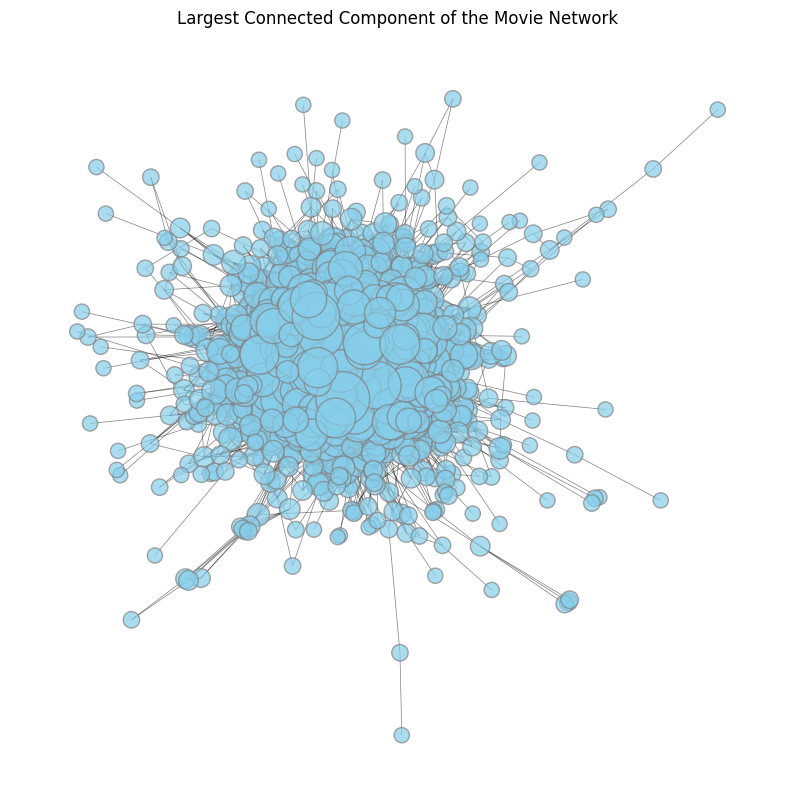

In [29]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

plt.title("Largest Connected Component of the Movie Network")
plt.axis("off")
plt.show()


### Network Visualisation

We used Graphistry tool to make an interactive visualisation of our network in order to use it in our presentation

In [30]:
# Data preprocessing for graphistry library needs

initial_pos = {n: np.random.rand(2) for n in graph_largest.nodes}
pos = nx.spring_layout(graph_largest, k=2.0, iterations=50, pos=initial_pos)

# Node DataFrame, including 'actors' attribute
nodes_df = pd.DataFrame.from_dict(dict(graph_largest.nodes(data=True)), orient='index')
nodes_df['degree'] = [graph_largest.degree[node] for node in graph_largest.nodes]
nodes_df['x'] = [pos[node][0] for node in graph_largest.nodes]
nodes_df['y'] =  [pos[node][1] for node in graph_largest.nodes]

# Edge DataFrame
edges_df = nx.to_pandas_edgelist(graph_largest)
edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

# Make the plot in the visualisation undirected
edges_df['edge'] = edges_df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)
undirected_edges_df = edges_df.drop_duplicates(subset='edge').drop(columns='edge').reset_index(drop=True)

# Replace non-numeric values with NaN and convert column to numeric
nodes_df['domestic'] = pd.to_numeric(nodes_df['domestic'], errors='coerce')
nodes_df['international'] = pd.to_numeric(nodes_df['international'], errors='coerce')
nodes_df["run_time"] = pd.to_numeric(nodes_df["run_time"], errors='coerce')

In [31]:
# Bind the nodes and edges to Graphistry, specifying the source, destination, and node key
# Set up Graphistry (replace with your credentials or use environment variables)

graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="michalis", password="FDKeHQR4EQg7pvb")

graphistry.bind(source="source", destination="target", point_x="x", point_y="y") \
    .edges(undirected_edges_df) \
    .nodes(nodes_df.reset_index(), node="index") \
    .encode_point_size("degree") \
    .plot()

Failed memoization speedup attempt due to Pandas internal hash function failing. Continuing without memoization speedups.This is fine, but for speedups around skipping re-uploads of previously seen tables, try identifying which columns have types that Pandas cannot hash, and convert them to hashable types like strings.


## Network sentiment analysis

#### Node Sizes by Degree and Colors by Sentiment (Red to Green)

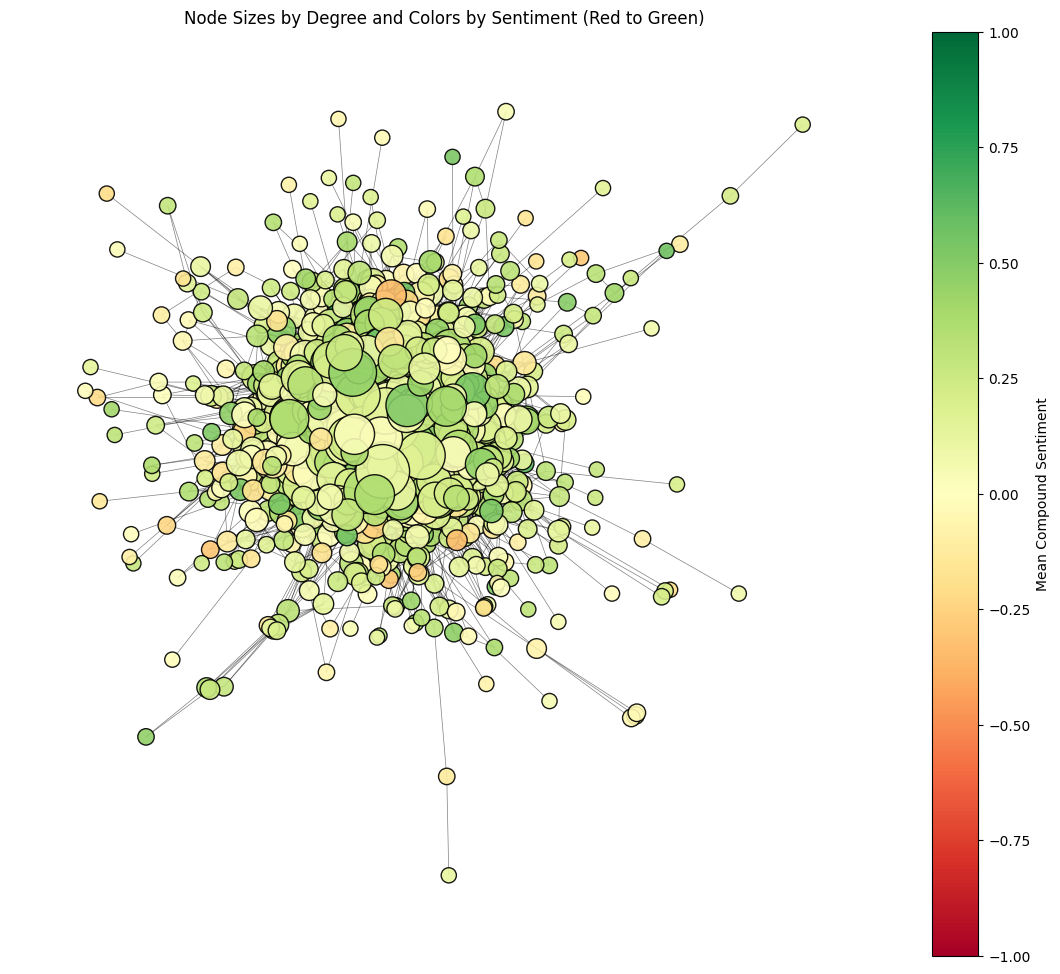

In [32]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

# Extract sentiment values
sentiments = [graph_largest.nodes[node]['avg_sentiment'] for node in graph_largest.nodes]

# Map sentiment values to a Red-to-Green color gradient
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# Create a ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size (degree) and color (sentiment)
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes by Degree and Colors by Sentiment (Red to Green)")
plt.axis("off")
plt.show()


#### Distribution of Mean Compound Sentiment

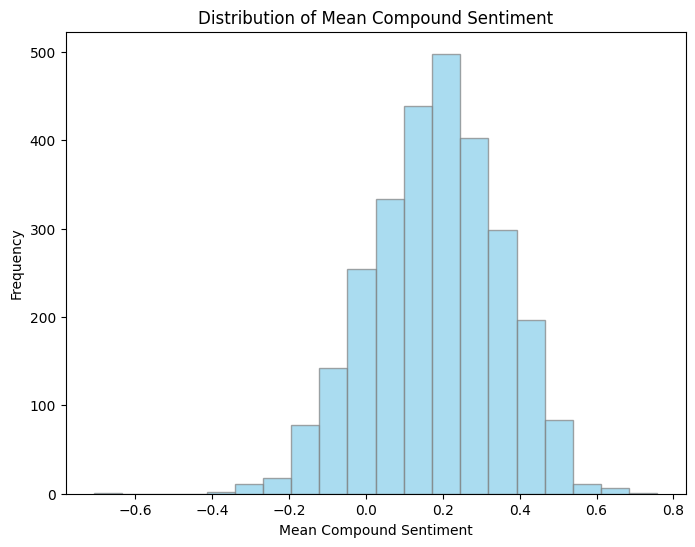

In [33]:
# Extract mean compound sentiment values
sentiments = [graph_largest.nodes[node]['avg_sentiment'] for node in graph_largest.nodes]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=20, color='skyblue', edgecolor='gray', alpha=0.7)
plt.title("Distribution of Mean Compound Sentiment")
plt.xlabel("Mean Compound Sentiment")
plt.ylabel("Frequency")
plt.show()


#### Average Sentiment Over Time

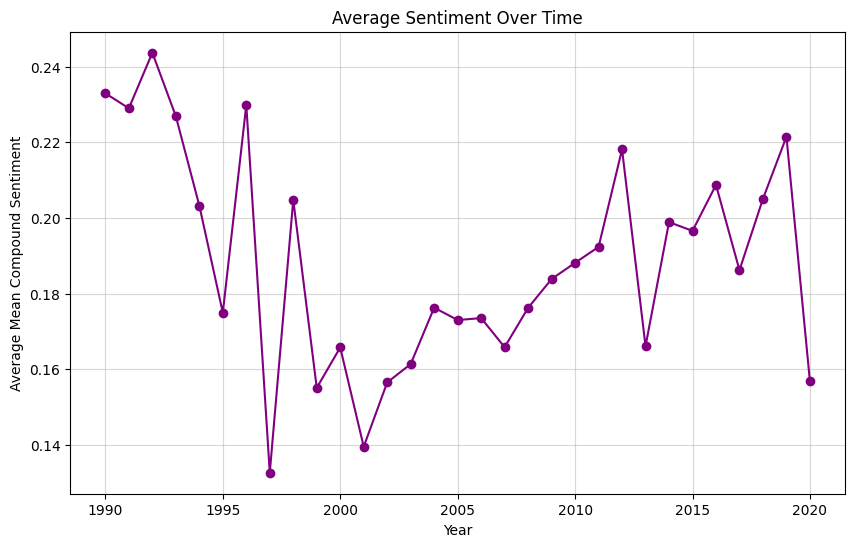

In [34]:
# Group sentiment by release year
years = [graph_largest.nodes[node]['release_year'] for node in graph_largest.nodes]
data = pd.DataFrame({'year': years, 'sentiment': sentiments})

# Calculate average sentiment per year
avg_sentiment_per_year = data.groupby('year')['sentiment'].mean()

# Line plot
plt.figure(figsize=(10, 6))
avg_sentiment_per_year.plot(color='purple', marker='o')
plt.title("Average Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Mean Compound Sentiment")
plt.grid(alpha=0.5)
plt.show()


#### Top 10 Positive and Negative Sentiment Nodes

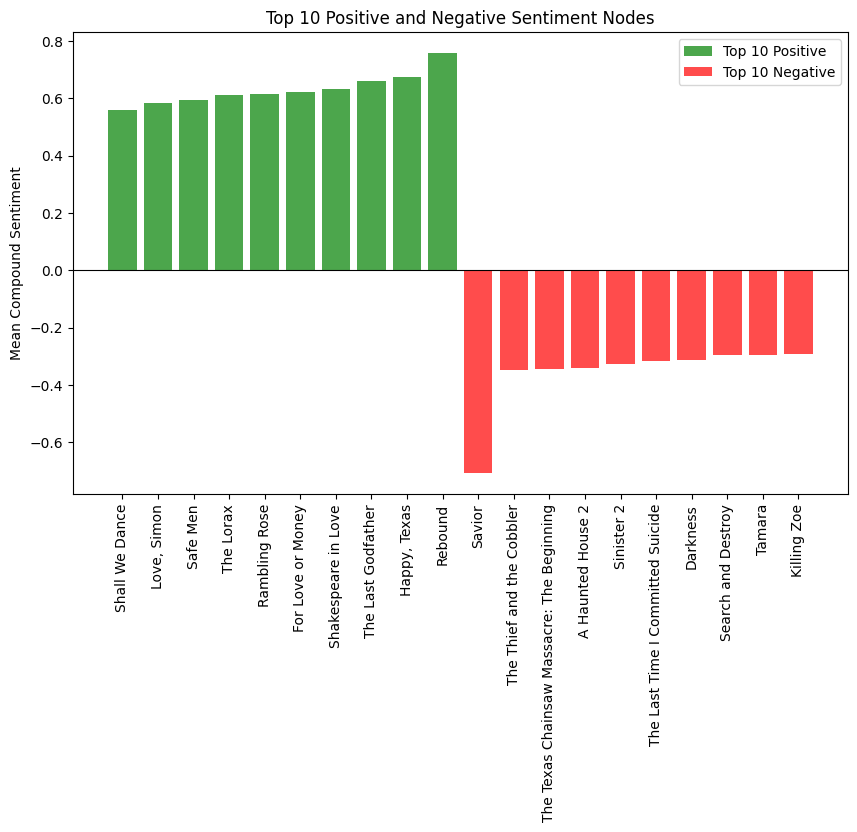

In [35]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(graph_largest.nodes, key=lambda node: graph_largest.nodes[node]['avg_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [graph_largest.nodes[node]['avg_sentiment'] for node in top_10]
bottom_sentiments = [graph_largest.nodes[node]['avg_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


#### Comparing the sentiment calculated with the Rotten Tomato critic score.

In [37]:
scores = [(movie_graph.nodes[movie]['mean_compound_sentiment'], graph_largest.nodes[movie]['tomatoMeter']) 
          for movie in graph_largest.nodes
          if not (np.isnan(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isnan(graph_largest.nodes[movie]['tomatoMeter']) or
                   np.isinf(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isinf(graph_largest.nodes[movie]['tomatoMeter']))]

# Correlation between the sentiment of the movie and the tomatoMeter
pearson_corr, pearson_p = stats.pearsonr([score[0] for score in scores], [score[1] for score in scores])
spearman_corr, spearman_p = stats.spearmanr([score[0] for score in scores], [score[1] for score in scores])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.9f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.9f})")

Pearson correlation: 0.544 (p-value: 0.000000000)
Spearman correlation: 0.549 (p-value: 0.000000000)


Text(0, 0.5, 'TomatoMeter')

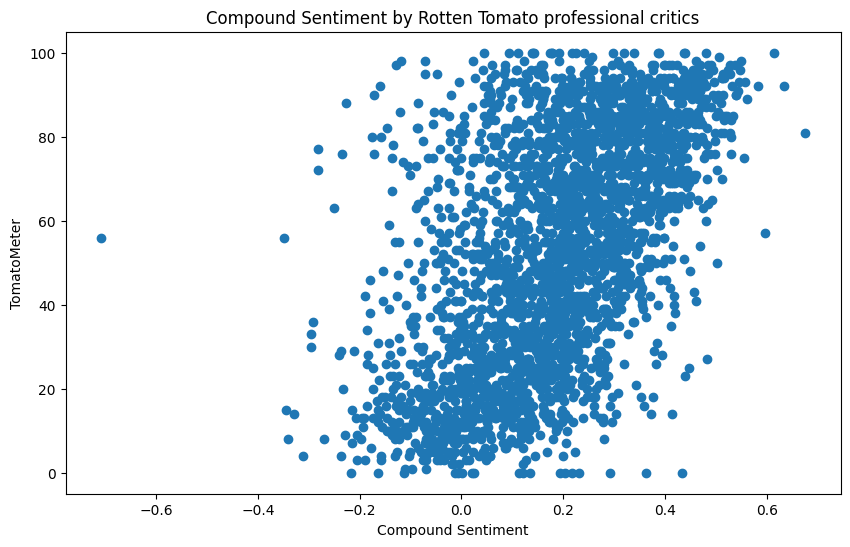

In [38]:
# compare with the sentiment
fig2, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter([score[0] for score in scores], [score[1] for score in scores])
ax3.set_title("Compound Sentiment by Rotten Tomato professional critics")
ax3.set_xlabel("Compound Sentiment")
ax3.set_ylabel("TomatoMeter")

#### Network homophily based on sentiment

Homophily measures the tendency of individuals to associate and bond with similar others in a network. In our case, we will calculate how similar the sentiments of connected movies are. This could reveal if actor-driven sentiment spreads across the network

In [39]:
# Shuffle graph edges
nswap = 10 * graph.number_of_edges()
shuffled_graph = nx.double_edge_swap(graph.copy(), nswap=nswap, max_tries=nswap * 2)

# Define similarity function for shuffled graph
avg_sentiment_per_node = nx.get_node_attributes(graph, 'avg_sentiment')
range_of_values = max(avg_sentiment_per_node.values()) - min(avg_sentiment_per_node.values())

def similarity(u, v):
    return 1 - abs(avg_sentiment_per_node[u] - avg_sentiment_per_node[v]) / range_of_values

# Calculate observed mean similarity
similarities = [similarity(u, v) for u, v in graph.edges]
mean_similarity_observed = np.mean(similarities)

# Calculate null mean similarity on shuffled graph
null_similarities = [similarity(u, v) for u, v in shuffled_graph.edges]
mean_similarity_null = np.mean(null_similarities)

# Compare observed and null similarities
homophily_index = (mean_similarity_observed - mean_similarity_null) / mean_similarity_null

print(f"Observed Mean Similarity: {mean_similarity_observed}")
print(f"Null Mean Similarity: {mean_similarity_null}")
print(f"Homophily Index: {homophily_index}")


Observed Mean Similarity: 0.8858660491548027
Null Mean Similarity: 0.8798721054634437
Homophily Index: 0.006812289711357378


Homophily index value is approximately 0.01. This indicates that nodes that are connected do not have a much larger similarity of sentiment than they would have if they were randomly connected.


## Statistics on The Largest Component  
The next few block will show that there is correlation between the success metrics (profits, sentiment) and the popularity of the actors.

This block prepares data for analysing how **actor popularity** relates to movie profit.

We do the following:

- Update the `actor_to_movies` dictionary so that each actor is mapped to the list of movies they appeared in.
- Build an **actor collaboration network** where two actors are connected if they appear in the same movie.
- Compute an **influence-based popularity score** for each actor using **PageRank** on this collaboration network.
- Compute `actor_avg_earning`, the mean profit of the movies each actor played in.
- Convert these dictionaries into aligned lists so we can measure the relationship between **PageRank-based popularity** and **average earnings** per actor.


In [40]:
# Preparing the data for the analysis (PageRank-based actor popularity)

from collections import defaultdict
import numpy as np
import networkx as nx

# Map each actor to the set of movies they appeared in
actor_to_movies.clear()
for movie in graph_largest.nodes:
    actors = graph_largest.nodes[movie].get("actors", [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)

# Average earnings (profit) per actor, based on the movies they appeared in
actor_avg_earning = {
    actor: float(np.mean([graph_largest.nodes[movie]["profit"] for movie in movies]))
    for actor, movies in actor_to_movies.items()
    if len(movies) > 0
}

# Average sentiment per actor (based on movie-level sentiment)
actor_avg_sentiment = {
    actor: float(np.mean([graph_largest.nodes[movie]["avg_sentiment"] for movie in movies]))
    for actor, movies in actor_to_movies.items()
    if len(movies) > 0
}

# Build actor collaboration graph: connect actors who co-star in at least one movie
actor_graph = nx.Graph()
for movie in graph_largest.nodes:
    actors = [a for a in graph_largest.nodes[movie].get("actors", []) if a != "UNKNOWN"]
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            actor_graph.add_edge(actors[i], actors[j])

# Influence-based popularity metric via PageRank
pagerank_scores = nx.pagerank(actor_graph, alpha=0.85)
actor_pagerank = pagerank_scores  # dict: actor -> PageRank score

# Convert dictionaries to aligned lists: same actor order across lists
keys = sorted(set(actor_pagerank.keys()) & set(actor_avg_earning.keys()))
actor_pagerank_ls = [actor_pagerank[k] for k in keys]
actor_avg_earning_ls = [actor_avg_earning[k] for k in keys]

# Also keep actor sentiment aligned for potential later analysis
actor_avg_sentiment_ls = [actor_avg_sentiment.get(k, np.nan) for k in keys]


Here we quantify how **influence-based actor popularity** relates to profit.

We use the PageRank score from the actor collaboration network as our popularity metric and compute:

- **Pearson correlation** between actor PageRank and their average movie profit.
- **Spearman correlation**, which is robust to non-linear monotonic relationships.
- A **simple linear regression** with PageRank as the predictor and average earnings as the response.

Note: the regression is performed at the actor level: for each actor we use
- their PageRank score in the collaboration network, and
- the mean profit of the movies they appeared in.


In [41]:
# Calculate the Pearson and Spearman correlation coefficients for PageRank vs earnings

from scipy import stats
import numpy as np

pearson_corr, pearson_p = stats.pearsonr(actor_pagerank_ls, actor_avg_earning_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_pagerank_ls, actor_avg_earning_ls)

print(f"""
Pearson correlation between actor PageRank (influence-based popularity) and average earnings: {pearson_corr:.3f} (p-value: {pearson_p:.3f})
""")
print(f"Spearman correlation between actor PageRank and average earnings: {spearman_corr:.3f} (p-value: {spearman_p:.3f})\n")


# Simple linear regression using PageRank binned into discrete levels for visualization
mean_by_pagerank = dict()
for pr, earning in zip(actor_pagerank_ls, actor_avg_earning_ls):
    # Optionally, bin PageRank values to avoid too many distinct x-values
    pr_bin = round(pr, 3)
    if pr_bin not in mean_by_pagerank:
        mean_by_pagerank[pr_bin] = [earning]
    else:
        mean_by_pagerank[pr_bin].append(earning)

mean_by_pagerank = {pr_bin: np.mean(earnings) for pr_bin, earnings in mean_by_pagerank.items()}

xs = np.array(list(mean_by_pagerank.keys()))
ys = np.array(list(mean_by_pagerank.values()))

slope, intercept, r, p, std_err = stats.linregress(xs, ys)
print(f"Linear regression (PageRank vs mean earnings): slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")



Pearson correlation between actor PageRank (influence-based popularity) and average earnings: 0.081 (p-value: 0.000)

Spearman correlation between actor PageRank and average earnings: 0.198 (p-value: 0.000)

Linear regression (PageRank vs mean earnings): slope=22688318968.599, intercept=48782617.497, r=0.989, p=0.093, std_err=3356367588.966


Pearson correlation (recency-weighted popularity vs earnings): 0.208 (p-value: 0.000)
Spearman correlation (recency-weighted popularity vs earnings): 0.417 (p-value: 0.000)


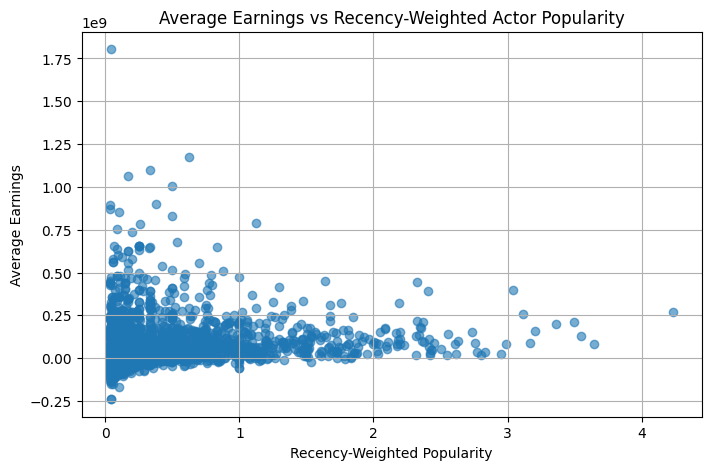

In [46]:
# Recency-weighted actor popularity

import numpy as np
from collections import defaultdict

# Determine reference year from the largest component
years = [
    graph_largest.nodes[movie].get("release_year")
    for movie in graph_largest.nodes
    if graph_largest.nodes[movie].get("release_year") != "UNKNOWN"
]
reference_year = max(years)

actor_recency_popularity = defaultdict(float)

for movie in graph_largest.nodes:
    year = graph_largest.nodes[movie].get("release_year")
    if year == "UNKNOWN":
        continue
    years_since = reference_year - year
    weight = 1.0 / (1.0 + years_since)

    actors = graph_largest.nodes[movie].get("actors", [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_recency_popularity[actor] += weight

# Align with earnings dictionary
common_actors = sorted(set(actor_recency_popularity.keys()) & set(actor_avg_earning.keys()))
actor_recency_ls = [actor_recency_popularity[a] for a in common_actors]
actor_recency_earnings_ls = [actor_avg_earning[a] for a in common_actors]

# Correlation and simple regression
from scipy import stats

pearson_corr_rec, pearson_p_rec = stats.pearsonr(actor_recency_ls, actor_recency_earnings_ls)
spearman_corr_rec, spearman_p_rec = stats.spearmanr(actor_recency_ls, actor_recency_earnings_ls)

print(f"Pearson correlation (recency-weighted popularity vs earnings): {pearson_corr_rec:.3f} (p-value: {pearson_p_rec:.3f})")
print(f"Spearman correlation (recency-weighted popularity vs earnings): {spearman_corr_rec:.3f} (p-value: {spearman_p_rec:.3f})")

# Optional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(actor_recency_ls, actor_recency_earnings_ls, alpha=0.6)
plt.xlabel("Recency-Weighted Popularity")
plt.ylabel("Average Earnings")
plt.title("Average Earnings vs Recency-Weighted Actor Popularity")
plt.grid(True)
plt.show()

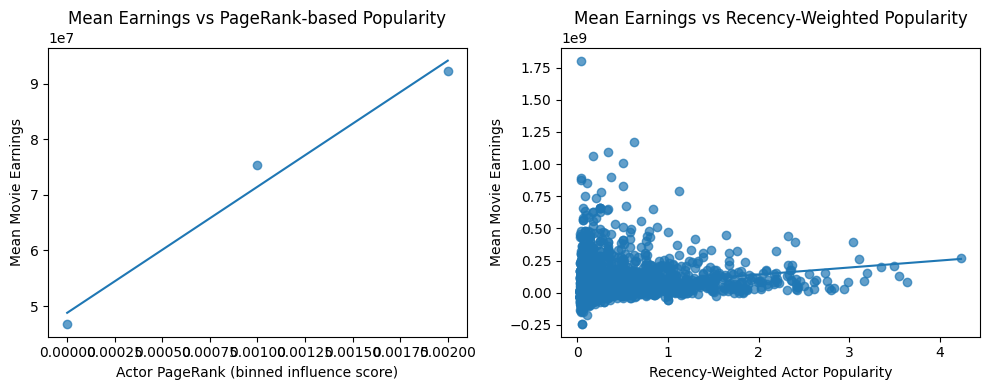

PageRank vs earnings: r = 0.989, p = 0.093
Recency vs earnings: r = 0.208, p = 0.000


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Panel (a): PageRank vs average earnings (binned) ---

# mean_by_pagerank was already computed in the PageRank analysis cell.
# If not, rebuild it here:
mean_by_pagerank = {}
for pr, earning in zip(actor_pagerank_ls, actor_avg_earning_ls):
    pr_bin = round(pr, 3)  # bin PageRank values
    mean_by_pagerank.setdefault(pr_bin, []).append(earning)

mean_by_pagerank = {pr_bin: np.mean(earnings) 
                    for pr_bin, earnings in mean_by_pagerank.items()}

xs_pr = np.array(list(mean_by_pagerank.keys()))
ys_pr = np.array(list(mean_by_pagerank.values()))

slope_pr, intercept_pr, r_pr, p_pr, std_err_pr = stats.linregress(xs_pr, ys_pr)

# --- Panel (b): Recency-weighted popularity vs average earnings ---

xs_rec = np.array(actor_recency_ls)
ys_rec = np.array(actor_recency_earnings_ls)

slope_rec, intercept_rec, r_rec, p_rec, std_err_rec = stats.linregress(xs_rec, ys_rec)

# --- Create the figure ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Panel (a): PageRank
ax1.scatter(xs_pr, ys_pr, alpha=0.7)
ax1.plot(
    np.sort(xs_pr),
    slope_pr * np.sort(xs_pr) + intercept_pr,
)
ax1.set_xlabel("Actor PageRank (binned influence score)")
ax1.set_ylabel("Mean Movie Earnings")
ax1.set_title("Mean Earnings vs PageRank-based Popularity")

# Panel (b): Recency-weighted popularity
ax2.scatter(xs_rec, ys_rec, alpha=0.7)
x_line = np.linspace(xs_rec.min(), xs_rec.max(), 200)
ax2.plot(x_line, slope_rec * x_line + intercept_rec)
ax2.set_xlabel("Recency-Weighted Actor Popularity")
ax2.set_ylabel("Mean Movie Earnings")
ax2.set_title("Mean Earnings vs Recency-Weighted Popularity")

plt.tight_layout()
plt.show()

print(f"PageRank vs earnings: r = {r_pr:.3f}, p = {p_pr:.3f}")
print(f"Recency vs earnings: r = {r_rec:.3f}, p = {p_rec:.3f}")


Here we calculate the following metrics for the popularity of the actors and sentiment
- Pearson correlation 
- Pearson p-value for the null hypothesist that they are uncorrelated
- same using Spearman correlation
- a simple linear regression between the popularity of the actors and sentiment that returns the slope, intercept, standard error estimate of the slope


NOTE the linear regression is done by getting the mean of all the (mean) profits for the actors that have acted in the same number of movies, i.e  if 2 actors acted in 2 movies the mean of the sentiment by each actor is again averaged.   

#### Total actor popularity compared with earnings and sentiment

#### Top 5 movies/actors for each centrality metrics

#### Plot centrality vs success metrics

#### Correlation between centrality and success metrics

## Community analysis

In [ ]:
##Functions to calculate modularity
def dict_to_subgraphs(communities,G):
  subgraphs = []
  for key in communities.keys():
    nodes = communities[key]
    subgraph = G.subgraph(nodes)
    subgraphs.append(subgraph)
  return subgraphs

def modularity(subgraphs,G):
  L_c = [subgraph.number_of_edges() for subgraph in subgraphs]
  K_c = [sum([G.degree(node) for node in subgraph.nodes()]) for subgraph in subgraphs]
  M = sum([
    (L_c[i]/G.number_of_edges())-
    ((K_c[i]/(2*G.number_of_edges()))**2) for i in range(len(L_c))])
  return M

### Communities by genre

#### Create communities based on the first genre of a movie

In [ ]:
## Find communities based on the first genre G
communities_first_genre = dict()
for node in graph_largest.nodes():
    if graph_largest.nodes(data=True)[node]["genres"][0] != "UNKNOWN":
        community = graph_largest.nodes(data=True)[node]["genres"][0]

        if community in communities_first_genre.keys():
            current = communities_first_genre[community]
            current.append(node)
            communities_first_genre[community]=current
        else:
            communities_first_genre.update({community:[node]})

num_communities = len(communities_first_genre)
print(f"Number of communities: {num_communities}")
print("Modularity based on genre", modularity(dict_to_subgraphs(communities_first_genre,graph_largest),graph_largest))

Number of communities: 14
Modularity based on genre 0.07607108018000766


#### Plot network with genre-based communities 

C:\Users\musti\AppData\Local\Temp\ipykernel_4900\4146585872.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))


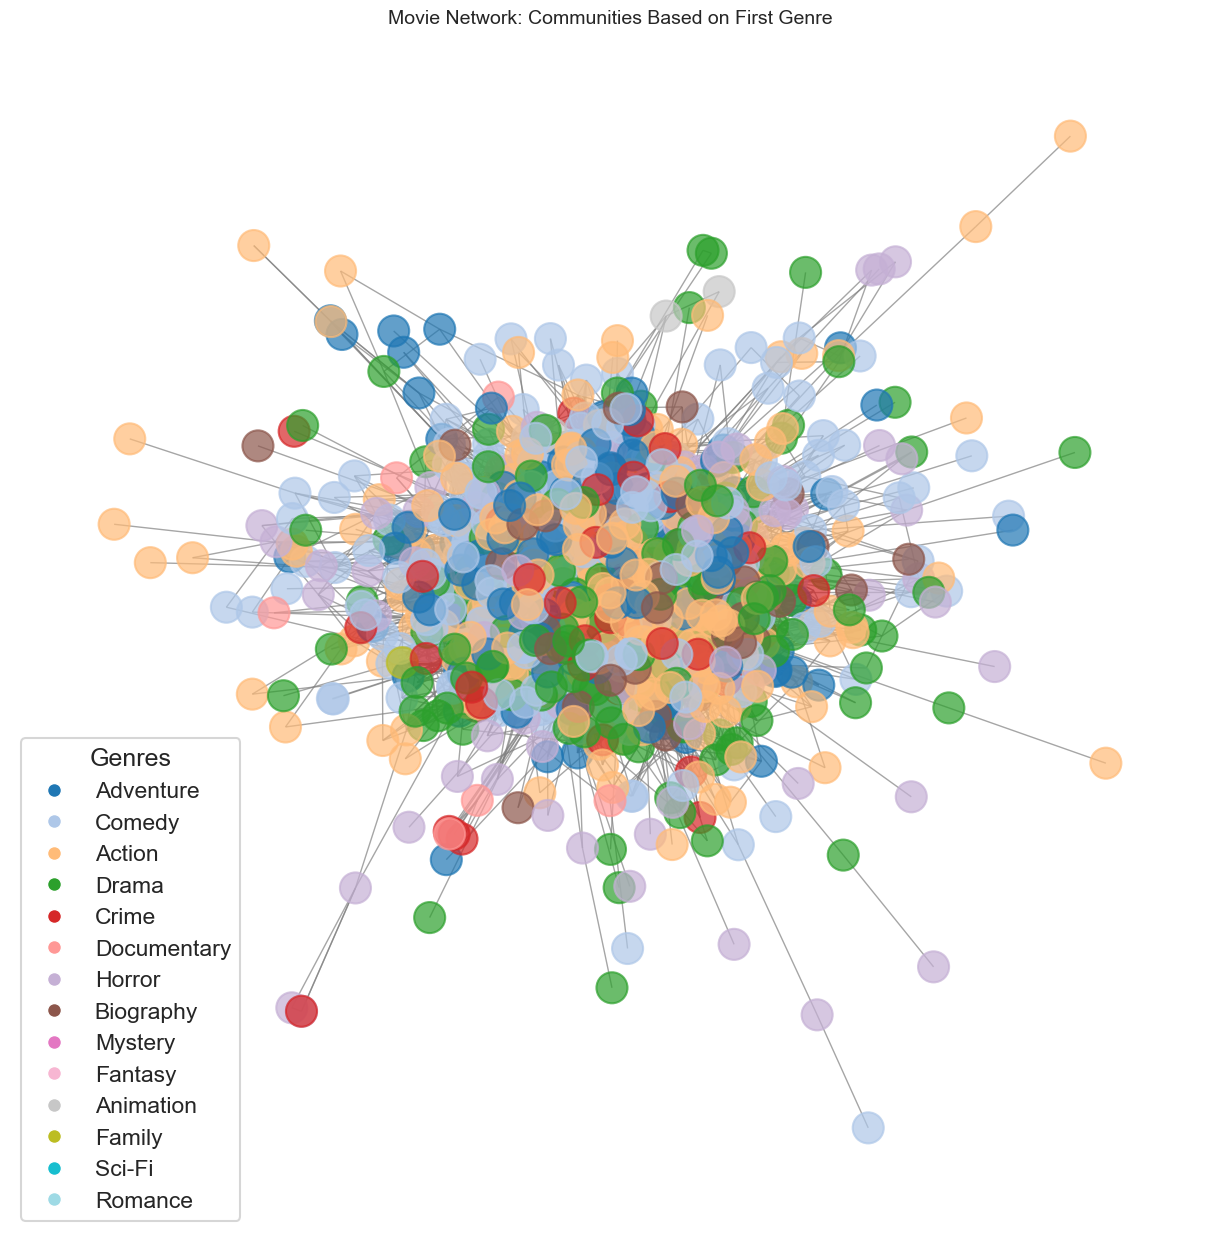

In [ ]:
# Generate a color map based on the communities (genres)
color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))

# Create a new plot
plt.figure(figsize=(12, 12))

# Create a list of colors for each node based on its genre community
node_colors = []
for node in graph_largest.nodes():
    # Get the first genre of the movie
    first_genre = graph_largest.nodes(data=True)[node]["genres"][0]
    
    if first_genre != "UNKNOWN":
        # Get the community index for the first genre
        community_idx = list(communities_first_genre.keys()).index(first_genre)
        node_colors.append(color_map(community_idx))
    else:
        node_colors.append((0.5, 0.5, 0.5))  # Default color for UNKNOWN genres

# Draw the network with communities as colors
pos = nx.spring_layout(graph_largest, seed=42)  # Layout for the graph (spring layout is just one option)
nx.draw(graph_largest, pos, node_color=node_colors, with_labels=False, node_size=500, font_size=10, font_weight="bold", edge_color="gray", alpha=0.7)

# Create a list of genres for the legend
genre_labels = list(communities_first_genre.keys())

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10) for i in range(len(genre_labels))]
plt.legend(handles, genre_labels, title="Genres", loc='best')
plt.title("Movie Network: Communities Based on First Genre", fontsize=14)
plt.show()

#### Sizes of communities

In [ ]:
community_sizes_df = pd.DataFrame(
    [(community, len(nodes)) for community, nodes in communities_first_genre.items()],
    columns=["Community", "Size"]
).sort_values(by="Size", ascending=False)

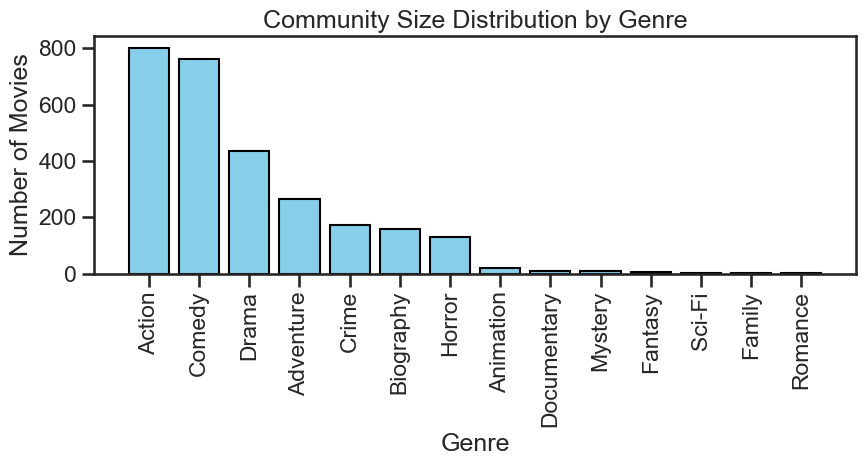

In [ ]:
plt.figure(figsize=(9, 5)) 
plt.bar(community_sizes_df["Community"], community_sizes_df["Size"], color="skyblue", edgecolor="black")

# Customize ticks and labels
plt.xticks(rotation=90, ha="center")  # Align x-axis labels vertically
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.title("Community Size Distribution by Genre")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


#### Density of communities

In [ ]:
subgraphs = dict_to_subgraphs(communities_first_genre, graph_largest)
densities_df = pd.DataFrame(
    [(list(communities_first_genre.keys())[i], nx.density(subgraph)) 
     for i, subgraph in enumerate(subgraphs)],
    columns=["Community", "Density"]
).sort_values(by="Density", ascending=False)

#### Average degree of communities

In [ ]:
avg_degrees = {key: sum([graph_largest.degree(node) for node in nodes]) / len(nodes)
               for key, nodes in communities_first_genre.items()}

#### Clustering coefficient for each community

In [ ]:
# Compute clustering coefficient for each community
community_clustering = [
    (
        community,  # Community name
        nx.average_clustering(graph_largest.subgraph(nodes))  # Average clustering coefficient for the subgraph
    )
    for community, nodes in communities_first_genre.items()
]

clustering_df = pd.DataFrame(community_clustering, columns=["Community", "Clustering Coefficient"]).sort_values(
    by="Clustering Coefficient", ascending=False
)

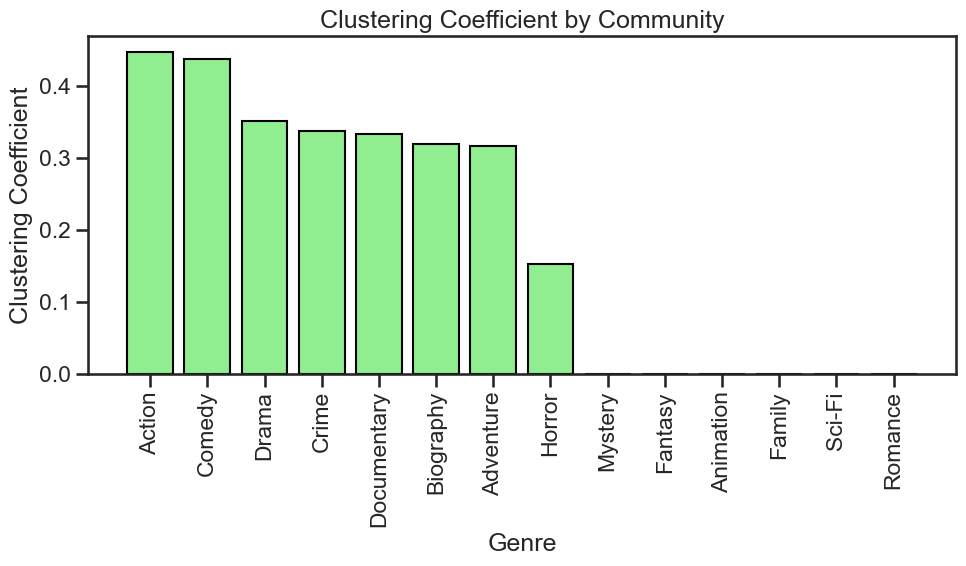

In [ ]:
# Bar plot for clustering coefficients
plt.figure(figsize=(10, 6))
plt.bar(clustering_df["Community"], clustering_df["Clustering Coefficient"], color="lightgreen", edgecolor="black")
plt.xticks(rotation=90, ha="center")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Genre")
plt.title("Clustering Coefficient by Community")
plt.tight_layout()
plt.show()

#### SUMMARY TABLE - size, density, avg. degree, avg clustering coefficient


In [ ]:
summary_df = pd.DataFrame(
    [
        (
            community,  # Community name
            len(nodes),  # Size (number of nodes in the community)
            nx.density(graph_largest.subgraph(nodes)),  # Density of the subgraph
            sum(graph_largest.degree(node) for node in nodes) / len(nodes),  # Average degree
            nx.average_clustering(graph_largest.subgraph(nodes)) # Average clustering coefficient for the subgraph
        )
        for community, nodes in communities_first_genre.items()
    ],
    columns=["Community", "Size", "Density", "Average Degree", "Avg. Clustering Coefficient"]
).sort_values(by="Size", ascending=False)

#### Inter-Community Edges


In [ ]:
# Map each node to its community
node_to_community = {
    node: community
    for community, nodes in communities_first_genre.items()
    for node in nodes
}

# Count inter-community edges
inter_community_edges = sum(
    1 for u, v in graph_largest.edges()
    if node_to_community.get(u) != node_to_community.get(v)
)

# Total edges
total_edges = graph_largest.number_of_edges()

# Proportion of inter-community edges
inter_community_ratio = inter_community_edges / total_edges

print(f"Number of inter-community edges: {inter_community_edges}")
print(f"Proportion of inter-community edges: {inter_community_ratio:.2f}")


Number of inter-community edges: 26870
Proportion of inter-community edges: 0.71


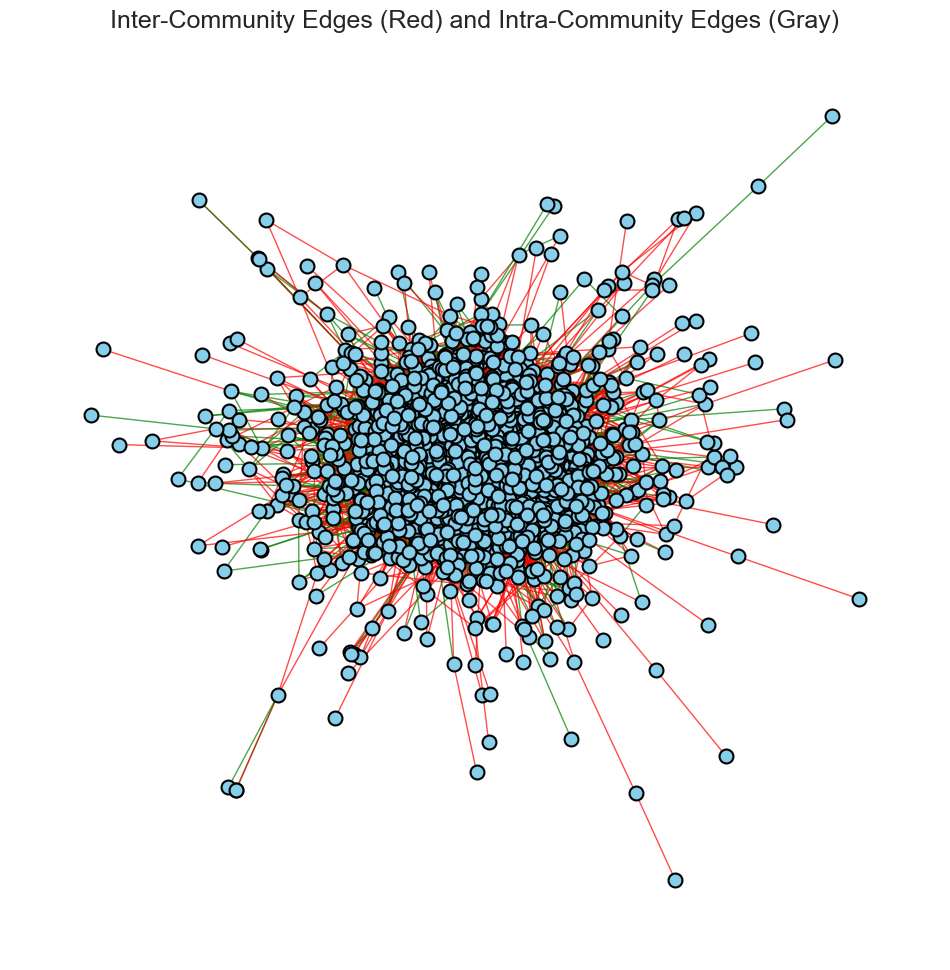

In [ ]:
edge_colors = [
    "red" if node_to_community.get(u) != node_to_community.get(v) else "green"
    for u, v in graph_largest.edges()
]

# Draw the graph with edge coloring
pos = nx.spring_layout(graph_largest, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(graph_largest, pos, node_color="skyblue", edgecolors="black", node_size=100)
nx.draw_networkx_edges(graph_largest, pos, edge_color=edge_colors, alpha=0.7)
plt.title("Inter-Community Edges (Red) and Intra-Community Edges (Gray)")
plt.axis("off")
plt.show()


#### Graphs of each genre community

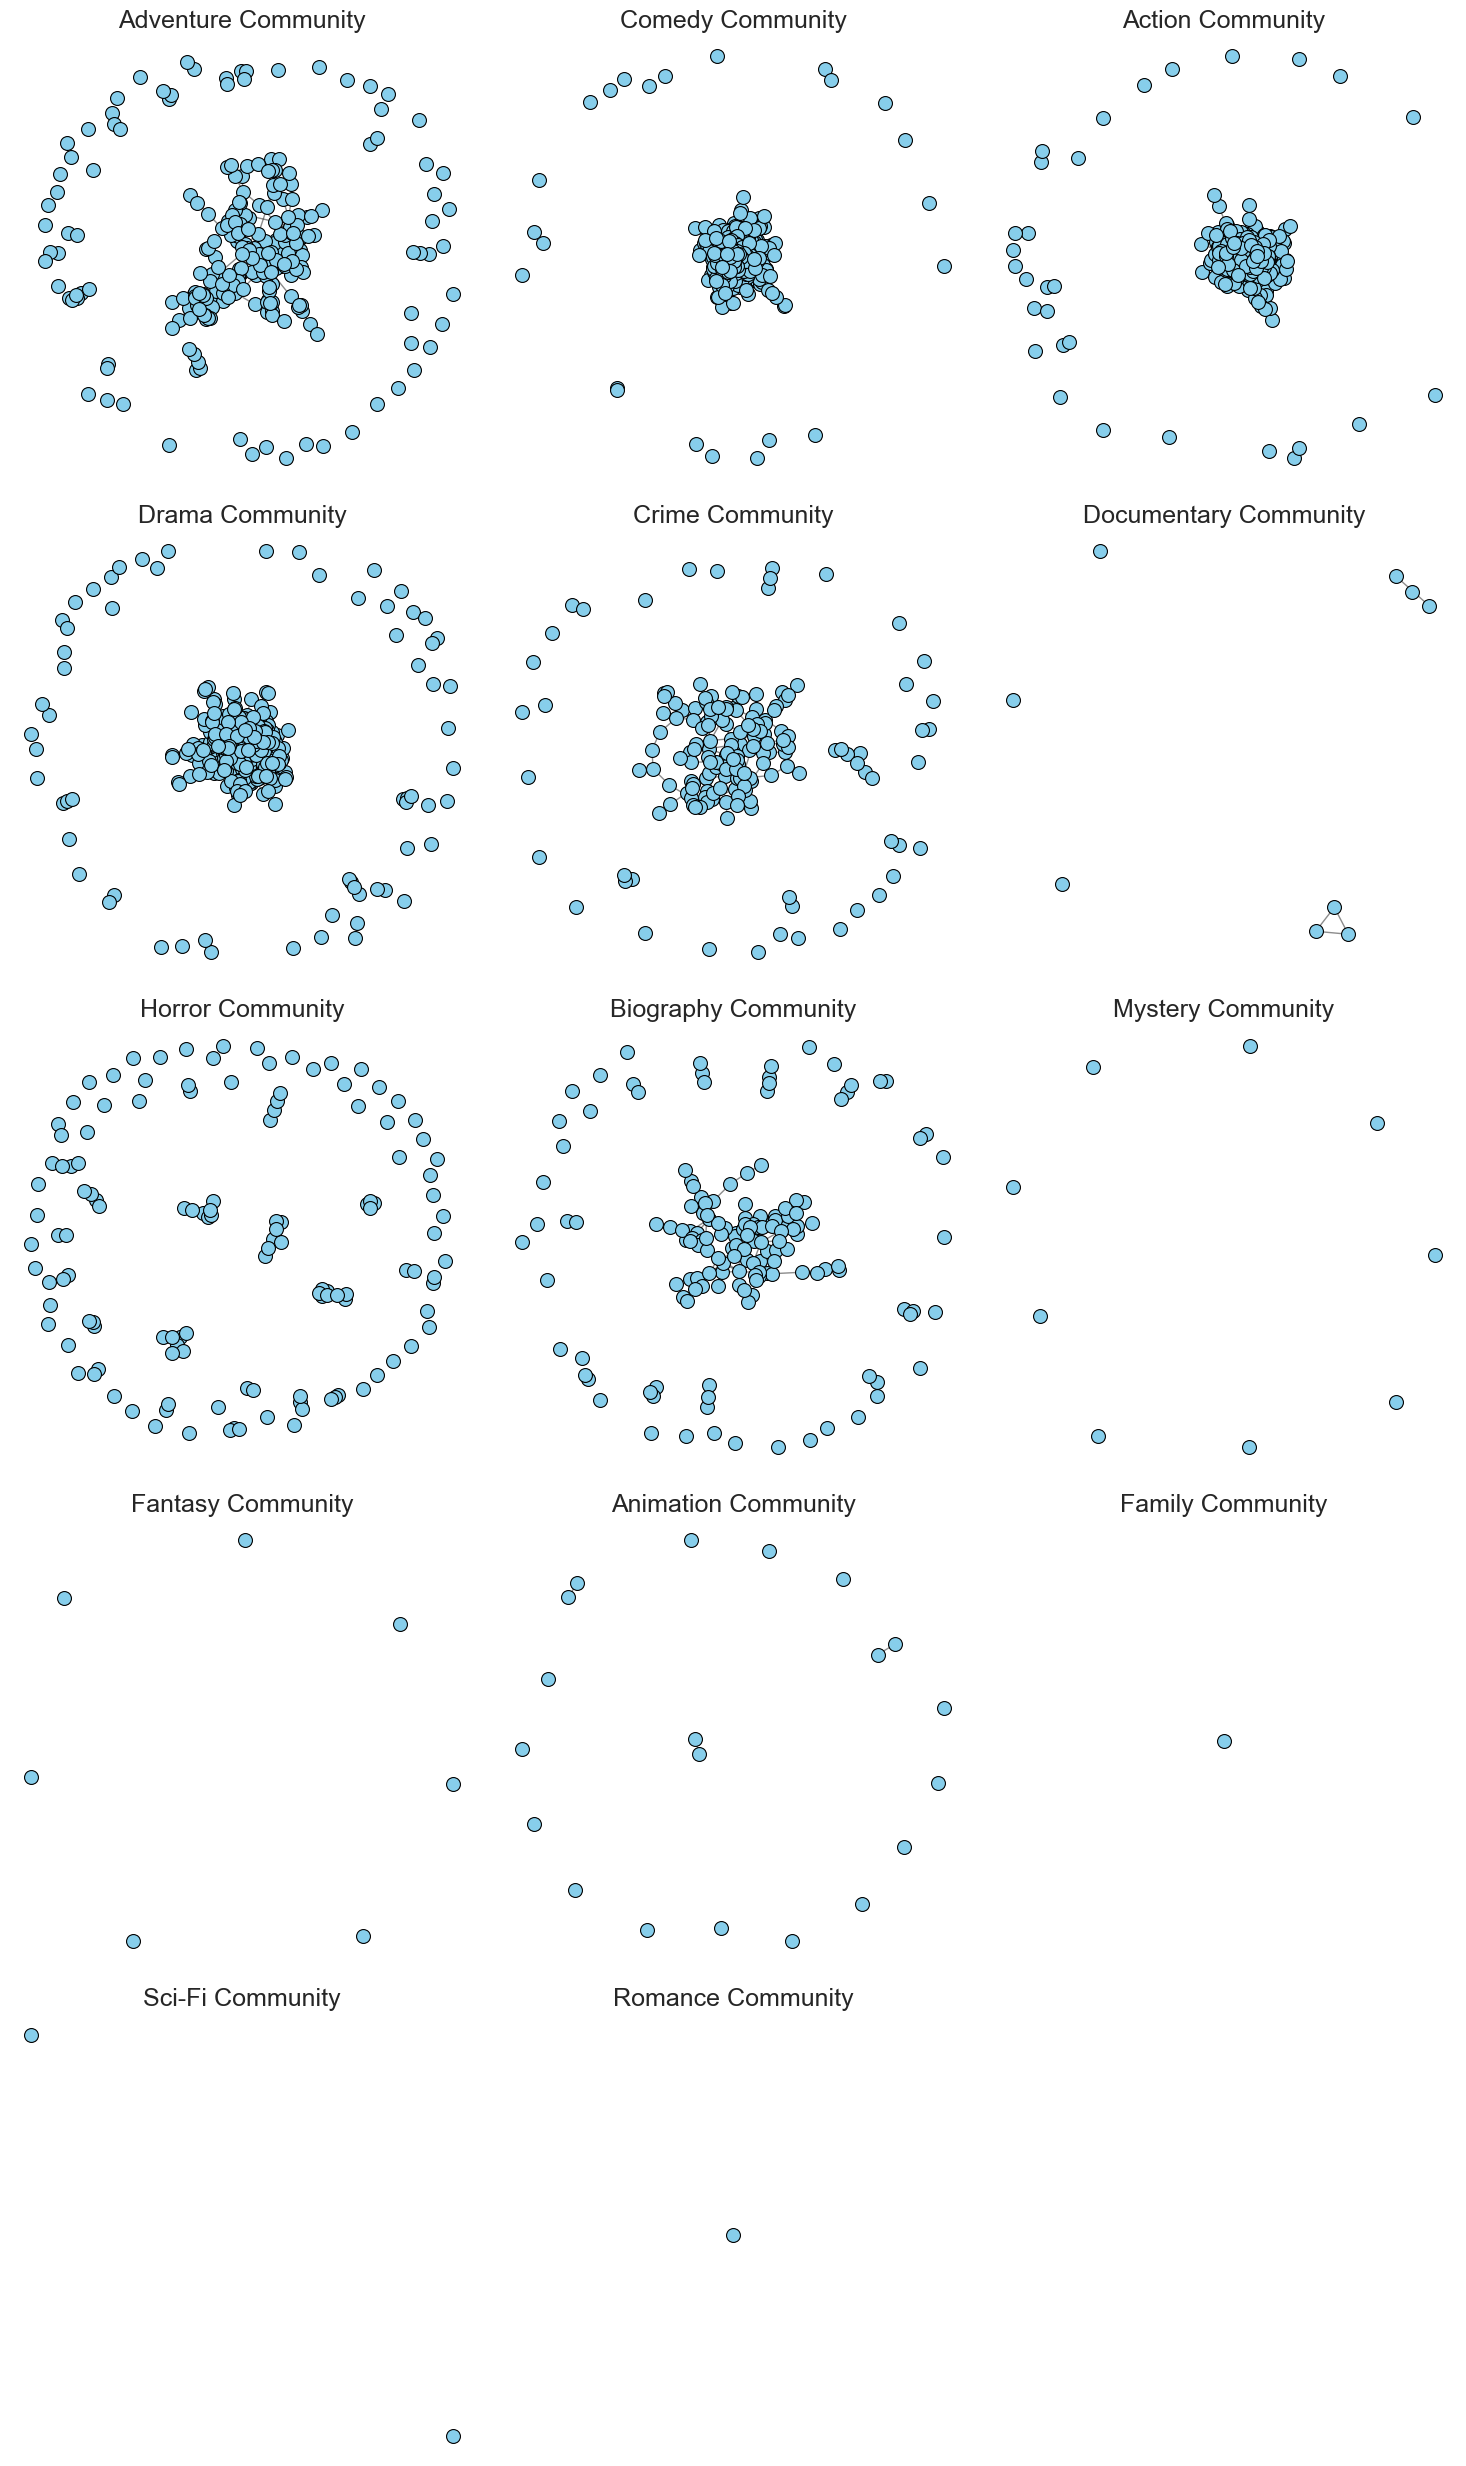

In [ ]:
num_communities = len(communities_first_genre)
cols = 3
rows = math.ceil(num_communities / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot each community in its subplot
for idx, (key, subgraph) in enumerate(zip(communities_first_genre.keys(), subgraphs)):
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw_networkx_nodes(subgraph, pos, 
                           ax=ax,
                           node_color='skyblue', 
                           edgecolors='black', 
                           linewidths=0.8, 
                           node_size=100)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5)

    ax.set_title(f"{key} Community")
    ax.axis("off")

for ax in axes[num_communities:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


### Communities by budget
Here we wil split movies based on tiers of budgets and put them in a communities, to see if spending more money on a movie means that you will earn more money.
The tiers are 
- 0 - 1,000,000
- 1,000,000 - 10,000,000
- 10,000,000 - 20,000,000
- 20,000,000 - 30,000,000
- 30,000,000 - 50,000,000
- 50,000,000 - 75,000,000
- 75,000,000 - 100,000,000
- 100,000,000 -200,000,000
- 200,000,000 +

In [ ]:
budget_Communities = {
    "0 - 1,000,000": [],
    "1,000,000 - 10,000,000": [],
    "10,000,000 - 20,000,000": [],
    "20,000,000 - 30,000,000": [],
    "30,000,000 - 50,000,000": [],
    "50,000,000 - 75,000,000": [],
    "75,000,000 - 100,000,000": [],
    "100,000,000 - 200,000,000": [],
    "200,000,000 +": []
}

# Assuming graph_largest is your graph
for node in graph_largest.nodes:
    budget = graph_largest.nodes[node]["budget"]
    if budget < 1000000:
        budget_Communities["0 - 1,000,000"].append(node)
    elif budget < 10000000:
        budget_Communities["1,000,000 - 10,000,000"].append(node)
    elif budget < 20000000:
        budget_Communities["10,000,000 - 20,000,000"].append(node)
    elif budget < 30000000:
        budget_Communities["20,000,000 - 30,000,000"].append(node)
    elif budget < 50000000:
        budget_Communities["30,000,000 - 50,000,000"].append(node)
    elif budget < 75000000:
        budget_Communities["50,000,000 - 75,000,000"].append(node)
    elif budget < 100000000:
        budget_Communities["75,000,000 - 100,000,000"].append(node)
    elif budget < 200000000:
        budget_Communities["100,000,000 - 200,000,000"].append(node)
    else:
        budget_Communities["200,000,000 +"].append(node)

budget_Communities_ROI ={
    category: [graph_largest.nodes[movie]["profit"]/graph_largest.nodes[movie]["budget"]
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_sentiment ={
    category: [graph_largest.nodes[movie]["avg_sentiment"] 
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_degree ={
    category: [graph_largest.degree(movie)
              for movie in movies]
    for category, movies in budget_Communities.items()
}



for category, values in budget_Communities.items():
    print(f"{category}: {np.mean([graph_largest.nodes[movie]["budget"] for movie in values]):,.3f} -  {len(values)}")


0 - 1,000,000: 383,928.348 -  25
1,000,000 - 10,000,000: 5,912,526.924 -  273
10,000,000 - 20,000,000: 15,103,195.891 -  334
20,000,000 - 30,000,000: 24,652,454.645 -  336
30,000,000 - 50,000,000: 39,632,422.415 -  586
50,000,000 - 75,000,000: 61,232,968.858 -  348
75,000,000 - 100,000,000: 86,605,395.556 -  268
100,000,000 - 200,000,000: 138,573,722.855 -  488
200,000,000 +: 241,425,174.817 -  119


In [ ]:
# Calculate the average profit for each budget category
budget_avg_ROI = {category: np.mean(values) 
                         for category, values in budget_Communities_ROI.items()}

budget_avg_sentiment = {category: np.mean(values) 
                         for category, values in budget_Communities_sentiment.items()}

formatted_profits = {k: f"{v:,.2f}" for k, v in budget_avg_ROI.items()}
formatted_sentiments = {k: f"{v:.3f}" for k, v in budget_avg_sentiment.items()}

for key in budget_Communities.keys():
    print(f"Category: {key} - Average ROI in multiplier: {formatted_profits[key]} - Average sentiment: {formatted_sentiments[key]}")
print("-----------------")



# Compute profit variance within communities
budget_variance_profit = {category: np.var(values) 
                             for category, values in budget_Communities_ROI.items()}
budget_variance_sentiment = {category: np.var(values) 
                             for category, values in budget_Communities_sentiment.items()}


formatted_variance_profit = {k: f"{v:.2e}" for k, v in budget_variance_profit.items()}
formatted_variance_sentiment = {k: f"{v:.3f}" for k, v in budget_variance_sentiment.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Variance ROI multiplier: {formatted_variance_profit[key]} - Variance sentiment: {formatted_variance_sentiment[key]}")

print("-----------------")
budget_avg_degree = {category: np.mean(values) for category, values in budget_Communities_degree.items()}
budget_variance_degree = {category: np.var(values) for category, values in budget_Communities_degree.items()}

formatted_avg_degree = {k: f"{v:.2f}" for k, v in budget_avg_degree.items()}
formatted_variance_degree = {k: f"{v:.2f}" for k, v in budget_variance_degree.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Average degree: {formatted_avg_degree[key]} - Variance degree: {formatted_variance_degree[key]}")



Category: 0 - 1,000,000 - Average ROI in multiplier: 119.62 - Average sentiment: 0.217
Category: 1,000,000 - 10,000,000 - Average ROI in multiplier: 4.54 - Average sentiment: 0.171
Category: 10,000,000 - 20,000,000 - Average ROI in multiplier: 2.03 - Average sentiment: 0.177
Category: 20,000,000 - 30,000,000 - Average ROI in multiplier: 1.36 - Average sentiment: 0.165
Category: 30,000,000 - 50,000,000 - Average ROI in multiplier: 1.13 - Average sentiment: 0.187
Category: 50,000,000 - 75,000,000 - Average ROI in multiplier: 0.96 - Average sentiment: 0.173
Category: 75,000,000 - 100,000,000 - Average ROI in multiplier: 0.93 - Average sentiment: 0.173
Category: 100,000,000 - 200,000,000 - Average ROI in multiplier: 1.00 - Average sentiment: 0.201
Category: 200,000,000 + - Average ROI in multiplier: 1.55 - Average sentiment: 0.222
-----------------
Category: 0 - 1,000,000 - Variance ROI multiplier: 2.48e+05 - Variance sentiment: 0.019
Category: 1,000,000 - 10,000,000 - Variance ROI multipl

We see that The sentiment on average increase as the budget increase. Moreover, the return on investment decreases as the budget increases. However, lower budget movies seems to have higher variance meaning that the ROI could be so much more, for example "The Blair Witch Project" move only had 60,000 budget but had 60,000 USD budget but it grossed more than 240 million USD. Furthermore, the sentiment seems to stabiles at higher budgets.  

Finally, The degree of each movie indicate the popularity of the actors playing in the movie. For lower budget the average degree is $\approx$ 7 and this increases as the budget increase. Which makes sense since having bigger budget means you are able to higher bigger actors  

In [ ]:
subgraphs = dict_to_subgraphs(budget_Communities, graph_largest)
print(f"Modularity: {modularity(subgraphs, graph_largest):.3f}")

Modularity: 0.023


### Louvain Communities

#### Modularity


In [ ]:
# Compute total actor popularity (number of appearances) for each movie node
appearances = nx.get_node_attributes(graph, 'actors')
flattened_appearances_list = list(chain.from_iterable(list(appearances.values())))
appearances_count = Counter(flattened_appearances_list)

for node, actors in appearances.items():
    total_actor_popularity = sum(appearances_count[actor] for actor in actors)
    graph.nodes[node]["total_actor_popularity"] = total_actor_popularity


In [ ]:
## louvain algorithm to partition the graph into communities
partition = community_louvain.best_partition(graph)
value_to_keys = {} #Fliping the keys and values
for key, value in partition.items():
    if value not in value_to_keys:
        value_to_keys[value] = []
    value_to_keys[value].append(key)

print("Modularity based on louvain", modularity(dict_to_subgraphs(value_to_keys,graph),graph))

Modularity based on louvain 0.4479785177073203


#### Average actor popularity, profit and sentiment within communities

In [ ]:
communities = dict_to_subgraphs(value_to_keys,graph)
average_popularities = []
average_sentiments = []
average_profits = []

# Keep communities with more than 10 nodes for statistically significant results
min_number_of_community_nodes = 50
sub_communities = [c for c in communities if c.number_of_nodes() >= min_number_of_community_nodes]
for community in sub_communities:

    number_of_movies = community.number_of_nodes()
    
    # Average popularity
    community_total_actor_popularities = nx.get_node_attributes(community, "total_actor_popularity")
    average_community_actor_popularity = sum(community_total_actor_popularities.values()) / number_of_movies
    average_popularities.append(average_community_actor_popularity)
    
    # Average sentiment
    community_sentiments = nx.get_node_attributes(community, "avg_sentiment")
    mean_sentiment = sum(community_sentiments.values()) / number_of_movies
    average_sentiments.append(mean_sentiment)
    
    # Average profit
    community_profits = nx.get_node_attributes(community, "profit")
    mean_profit = sum(community_profits.values()) / number_of_movies
    average_profits.append(mean_profit)


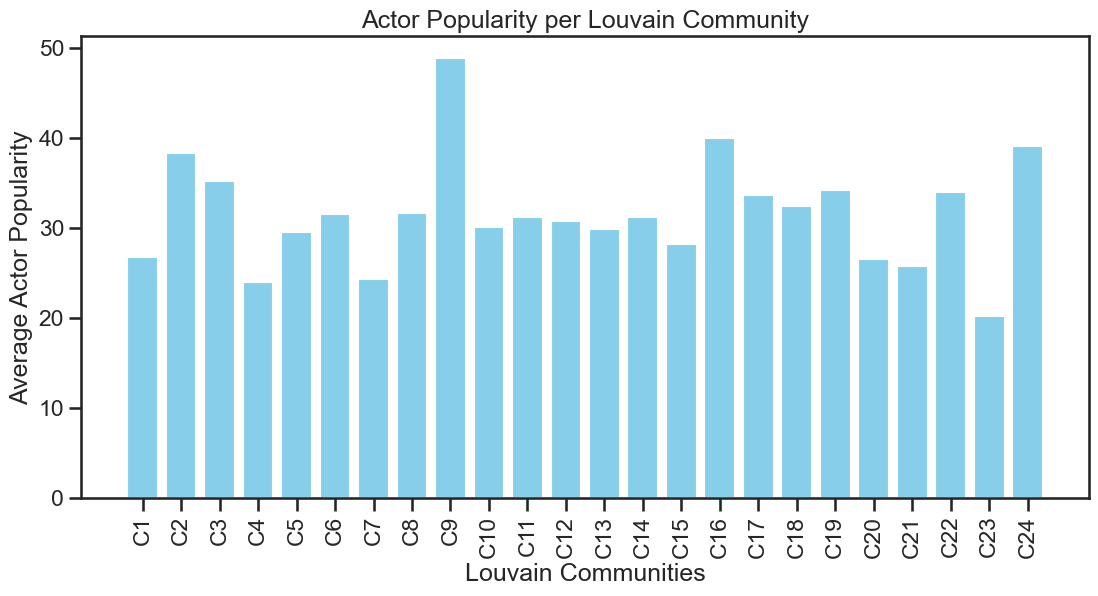

In [ ]:
# Example data
data = {
    'Community': [f"C{i+1}" for i in range(len(sub_communities))],
    'Popularity': average_popularities,
    'Sentiment': average_sentiments,
    'Profit': average_profits
}

# Convert data to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Popularity'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Actor Popularity')
plt.title('Actor Popularity per Louvain Community')
plt.show()

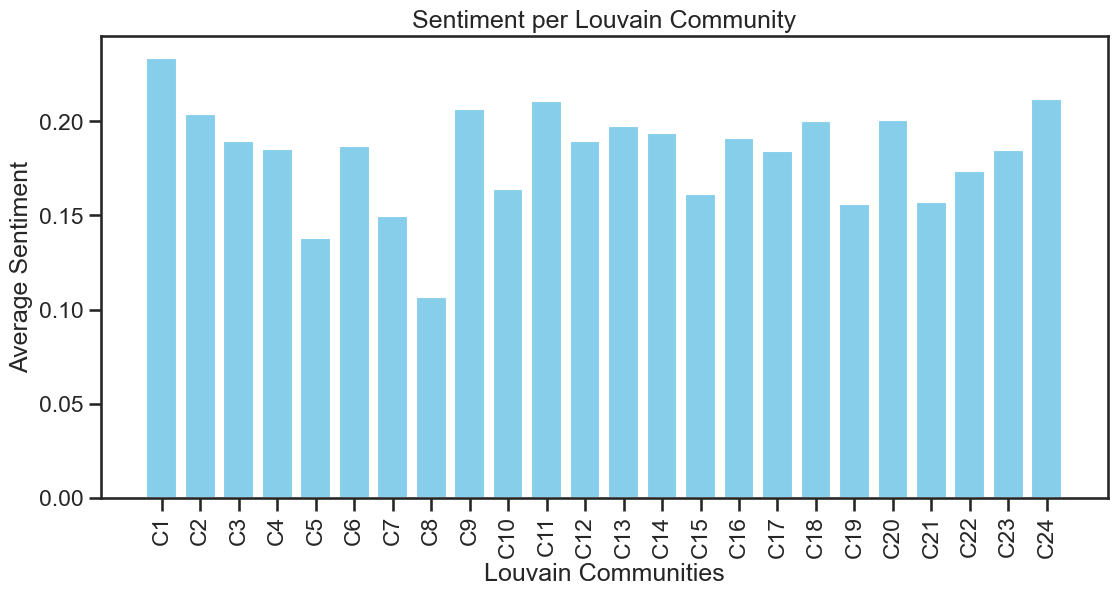

In [ ]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Sentiment'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Sentiment')
plt.title('Sentiment per Louvain Community')
plt.show()

Text(0.5, 1.0, 'Profit per Louvain Community')

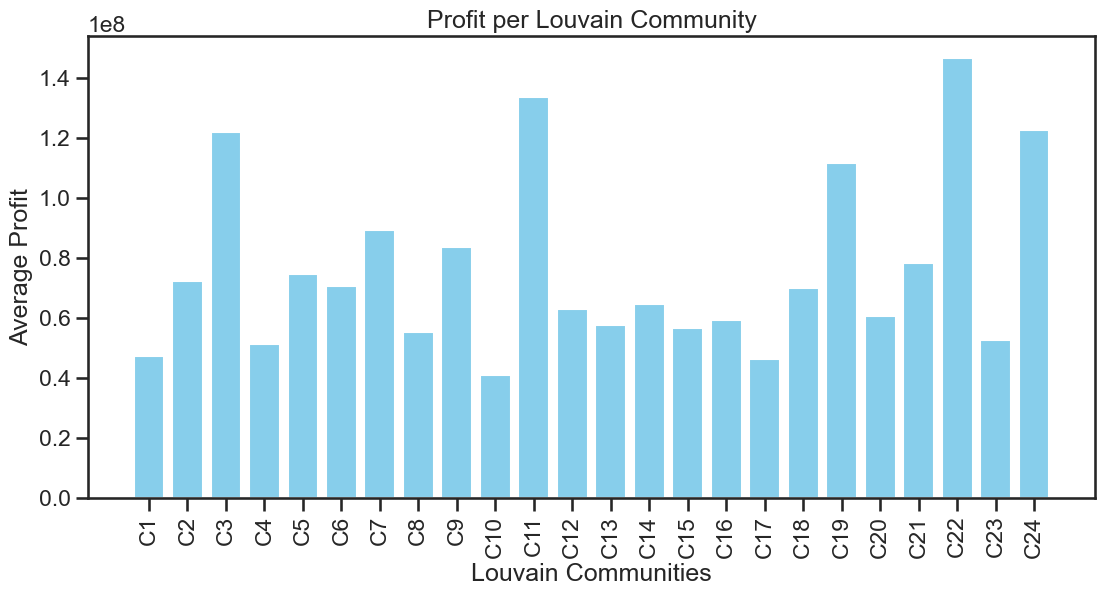

In [ ]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Profit'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Profit')
plt.title('Profit per Louvain Community')

#### Inter-community relationships

In [ ]:
# List of inter-community edges
inter_community_edges = [
    (u, v) for u, v in graph.edges()
    if partition[u] != partition[v]
]

# Find bridge nodes (nodes that have edges with other communities than the one they belong to
bridge_nodes = set([node for edge in inter_community_edges for node in edge])
community_connections = defaultdict(set)
for u, v in inter_community_edges:
    community_connections[u].add(partition[v])
    community_connections[v].add(partition[u])

inter_community_degree = {node: len(communities) for node, communities in community_connections.items()}
top__inter_community_nodes = sorted(inter_community_degree.items(), key=lambda item: item[1], reverse=True)[:10]

print("Top 10 Bridge Nodes:", top__inter_community_nodes)

Top 10 Bridge Nodes: [('Runaway Jury', 20), ('Twilight', 20), ('Stepmom', 20), ('The Contender', 20), ('The Cider House Rules', 20), ('Shall We Dance', 19), ('White Oleander', 19), ('The Italian Job', 19), ('Cyrus', 19), ('Closer', 19)]


#### Sentiment Analysis in Louvain communities

In [ ]:
# Group by Community and compute the variance of sentiment for communities
df.var(ddof=0, numeric_only=True).loc["Sentiment"]

np.float64(0.0007266877912548006)

The low variance that we observe indicates consistent audience sentiment between communities.

Our next goal is to identify whether highly connected communities (which in our case means that are communities with more popular actors) show higher sentiment.

In [ ]:
# Compute internal density for each community

def calculate_inter_community_density(communities):
    
    internal_densities = []
    
    for c in communities:
        num_nodes = c.number_of_nodes()
        num_edges = c.number_of_edges()
    
        internal_density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
        
        internal_densities.append(internal_density)
        
    return internal_densities

densities = calculate_inter_community_density(sub_communities)
df['Density'] = densities

In [ ]:
# Test if there is statistically significant correlation between the internal density of a community and its average sentiment

# Calculate the Pearson correlation coefficient and p-value
corr, p_value = stats.pearsonr(df['Density'], df['Profit'])

# Print results
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

# Check if p-value is less than significance level (e.g., 0.05)
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

spearman_corr, spearman_p = stats.spearmanr(df['Density'], df['Profit'])
# Print results
print(f"\n\nSpearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_p}")

# Check if p-value is less than significance level (e.g., 0.05)
if spearman_p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson correlation coefficient: 0.1260931628648444
P-value: 0.5571348439347201
The correlation is not statistically significant.


Spearman correlation coefficient: 0.06869565217391303
P-value: 0.749764493394595
The correlation is not statistically significant.


#### Plot correlation of actor popularity, earnings and sentiment within communities

<Figure size 1500x1000 with 0 Axes>

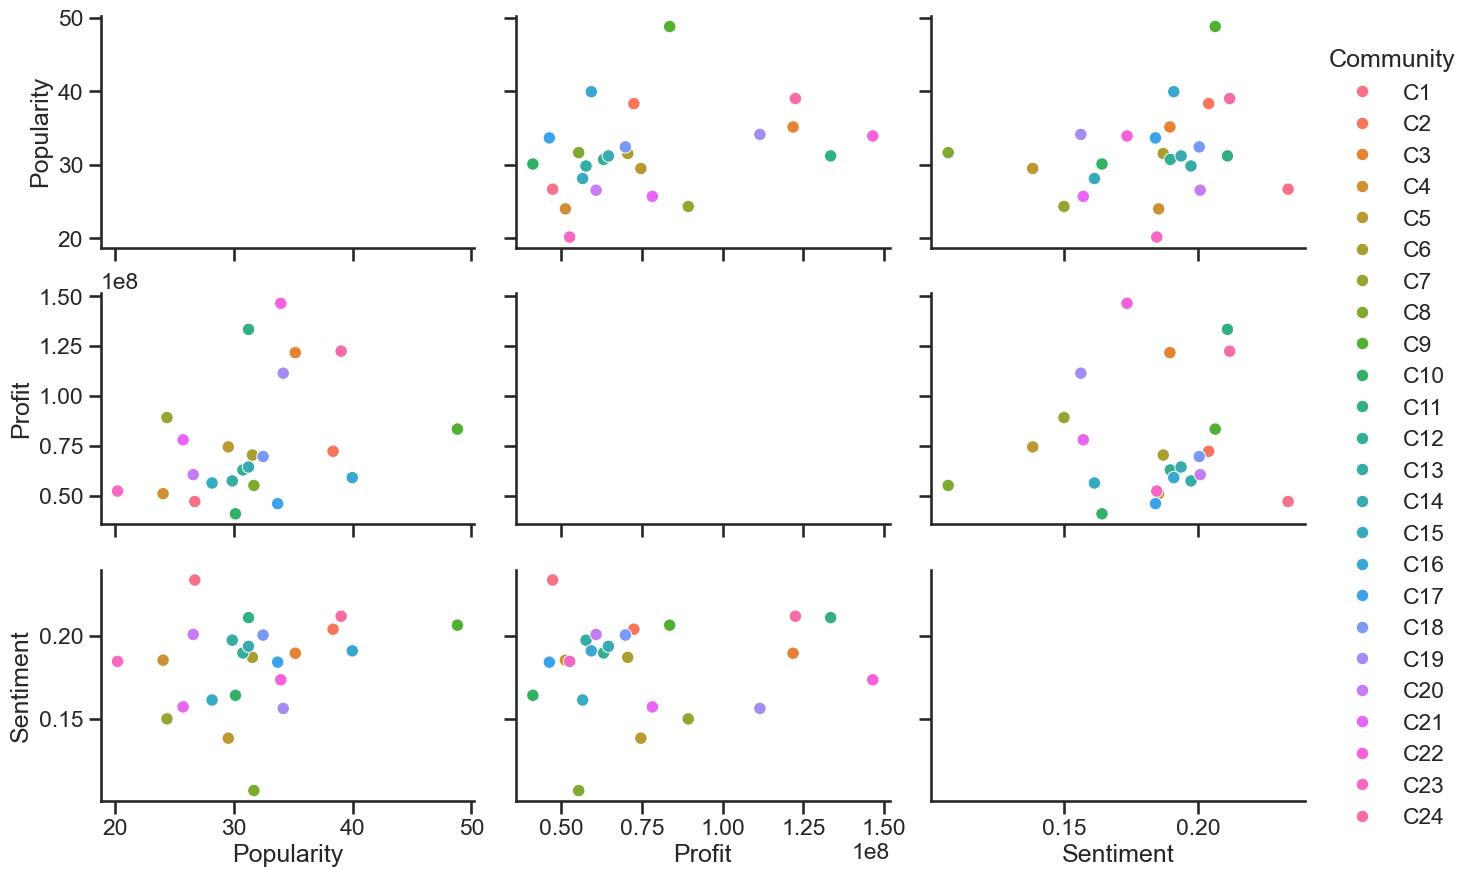

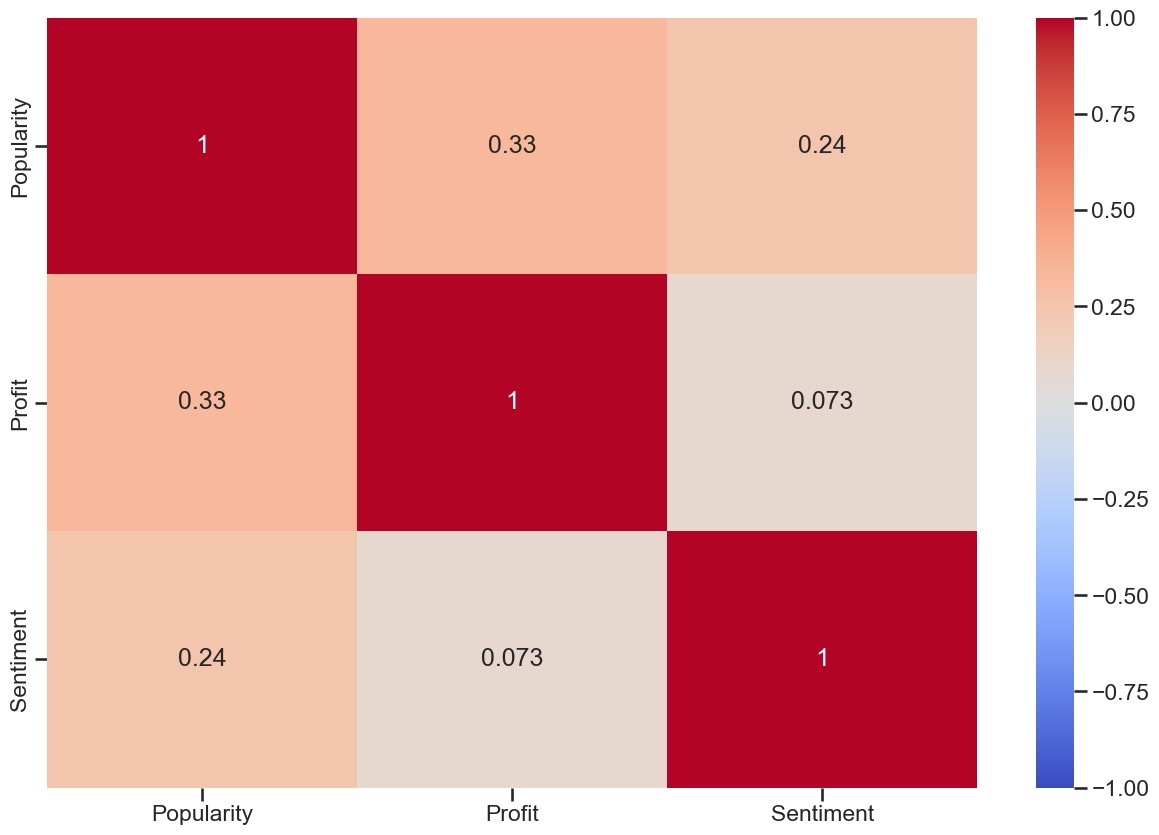

In [ ]:
# Plot Pairplot
fig = plt.figure(figsize=(15, 10))
sns.pairplot(df[['Community', 'Popularity', 'Profit', 'Sentiment']], kind='scatter', hue='Community', markers='o', height=3, aspect=1.5)
plt.savefig("communities_scatter_plot.png", dpi=600, bbox_inches='tight')
plt.show()

# Correlation matrix heatmap with same size as pairplot
plt.figure(figsize=(15, 10))  # Same width and height as pairplot
corr_matrix = df[['Popularity', 'Profit', 'Sentiment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig("communities_heatmap.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
                
set_node_community(graph, communities)
set_edge_community(graph)

#### Plot top-6 Louvain communities

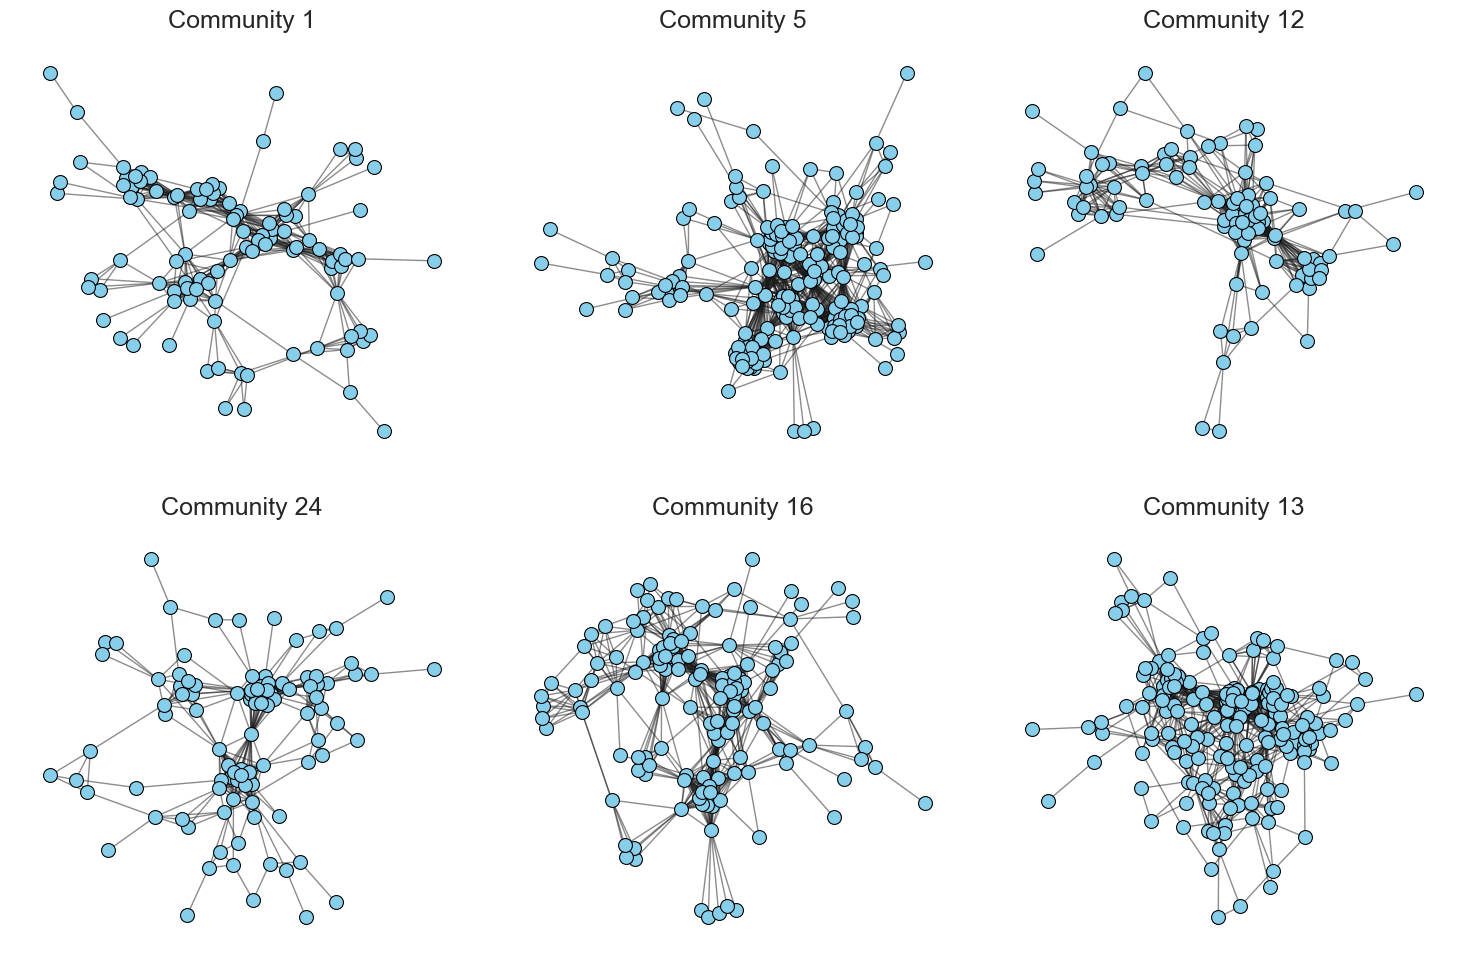

In [ ]:
# Plot preprocessing
num_communities = 6
cols = 3
rows = math.ceil(num_communities / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Sort dictionary and get top 6 communities
sorted_items = sorted(value_to_keys.items(), key=lambda item: len(item[1]), reverse=True)
top_communities = dict(sorted_items[:num_communities])

# Plot each community in its subplot
for idx, (key, subgraph) in enumerate(zip(top_communities.keys(), communities)):
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw_networkx_nodes(subgraph, pos, 
                           ax=ax,
                           node_color='skyblue', 
                           edgecolors='black', 
                           linewidths=0.8, 
                           node_size=100)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5)

    ax.set_title(f"Community {key}")
    ax.axis("off")

for ax in axes[num_communities:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.savefig("louvain_top_communities.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# Top communities subgraph
num_communities = 8

# Sort dictionary and get top communities
sorted_items = sorted(value_to_keys.items(), key=lambda item: len(item[1]), reverse=True)
top_communities = dict(sorted_items[:num_communities])

# Create a subgraph with nodes from the top 8 communities
top_nodes = []
for comm in top_communities:
    top_nodes.extend(top_communities[comm])

top_communities_graph = graph.subgraph(top_nodes)


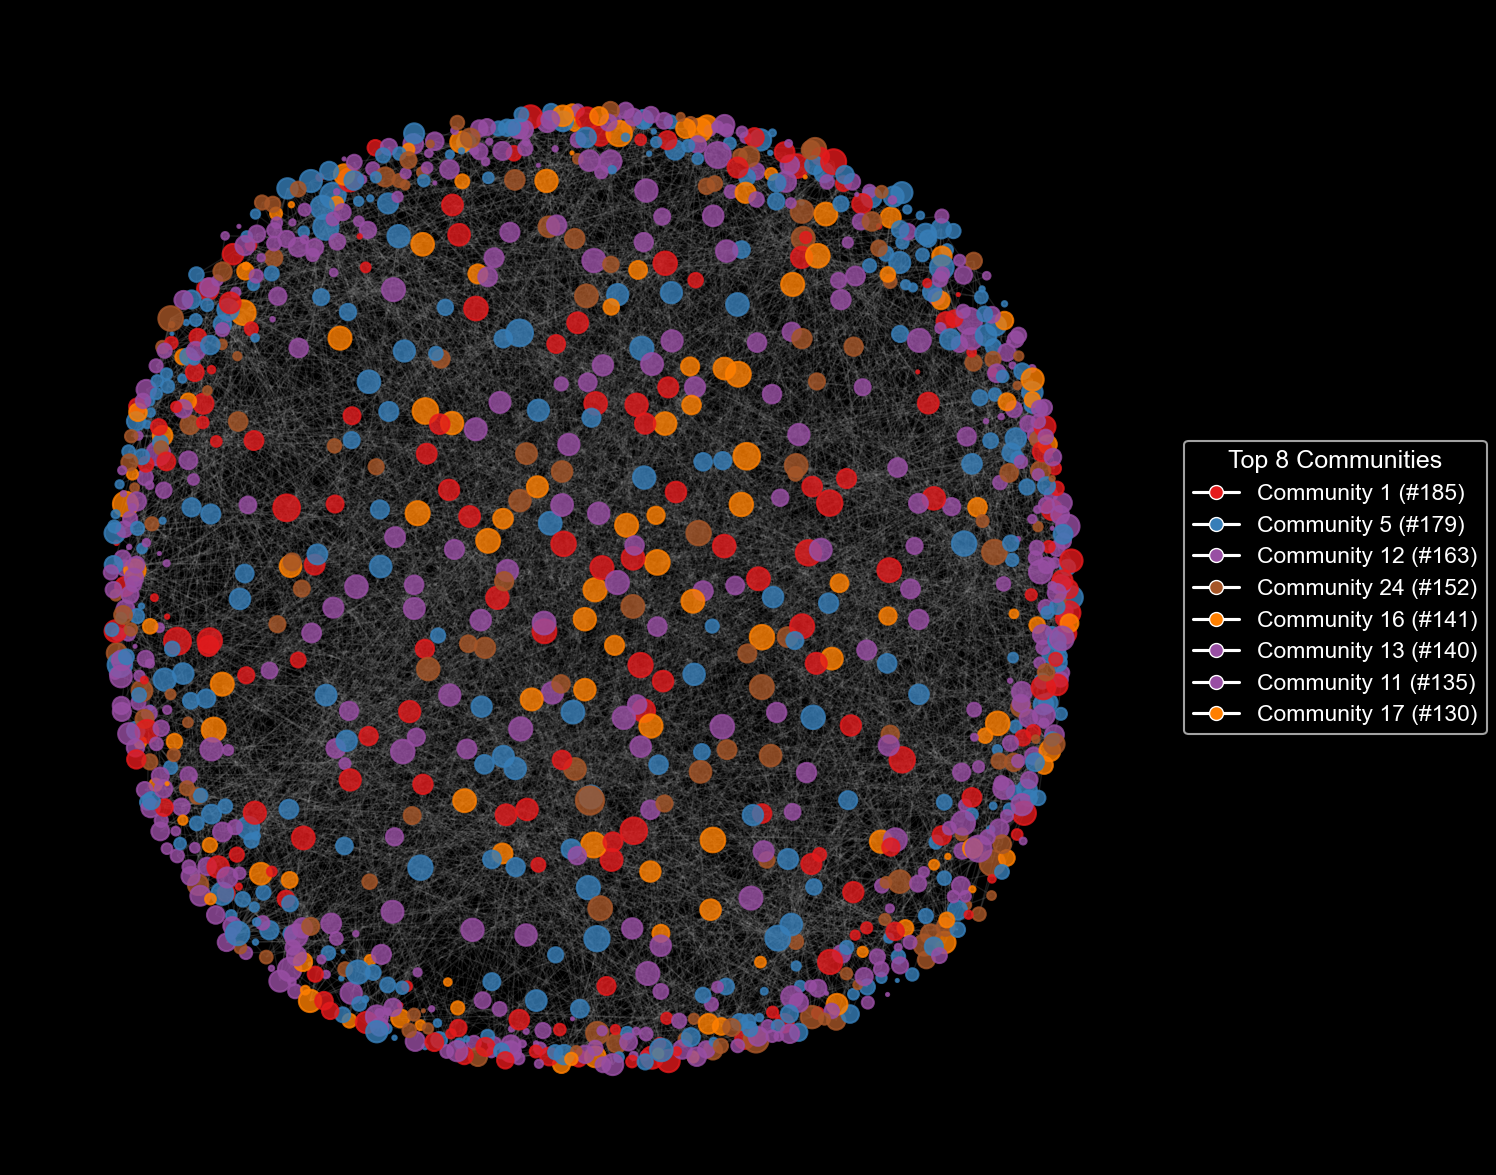

In [ ]:
# Adjust layout
pos = nx.spring_layout(top_communities_graph, k=1.2, scale=10)  # Increase scale to zoom in
plt.rcParams.update({'figure.figsize': (15, 15)})
plt.style.use('dark_background')

# External and internal edges
external = [(v, w) for v, w in top_communities_graph.edges if top_communities_graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in top_communities_graph.edges if top_communities_graph.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]

# Node colors
cmap = plt.get_cmap('Set1')  # You can change 'viridis' to any other colormap
norm = plt.Normalize(vmin=0, vmax=len(communities) - 1)
node_color = [cmap(norm(top_communities_graph.nodes[v]['community'])) for v in top_communities_graph.nodes]

# Calculate node size based on degree (larger degree = larger node)
degrees = {node: graph.degree(node) for node in graph}
node_size = [degrees[node] * 5 for node in top_communities_graph.nodes]  # Adjust the multiplier as needed

# Draw edges (background)
nx.draw_networkx_edges(
    top_communities_graph,
    pos=pos,
    edgelist=external,
    edge_color="silver",
    alpha=0.15
)
nx.draw_networkx_edges(
    top_communities_graph, 
    pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    alpha=0.05
)

# Draw nodes (foreground)
nx.draw_networkx_nodes(
    top_communities_graph,
    pos=pos,
    node_size=node_size,  # Increase node size for better visibility
    node_color=node_color,
    alpha=0.8,  # Make nodes more visible
)

# Add legend for community colors
handles = []
labels = []
for comm, nodes in top_communities.items():
    # Create a custom label for each community with its color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(comm)), markersize=10))
    labels.append(f"Community {comm} (#{len(nodes)})")

plt.legend(handles=handles, labels=labels, title=f"Top {num_communities} Communities", loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis("off")# Hide axes
plt.savefig("louvain_top_communities.png", dpi=400, bbox_inches='tight')
plt.show()


## Recency-Weighted Actor Popularity (Current Relevance)

In addition to cumulative popularity, we also measure how **recent** an actor's success is.

For each actor we define a recency-weighted popularity score:

$$
\text{Popularity(actor)} = \sum_{\text{movies}} \frac{1}{1 + \text{years\_since\_movie}}
$$

- A movie released in the most recent year gets weight close to 1.
- Older movies contribute less as they get further in the past.

We then relate this recency-weighted actor popularity to average profit, which lets us discuss whether **current relevance** has a stronger effect on financial success than lifetime popularity.


In [ ]:
# Recency-weighted actor popularity

import numpy as np
from collections import defaultdict

# Determine reference year from the largest component
years = [
    graph_largest.nodes[movie].get("release_year")
    for movie in graph_largest.nodes
    if graph_largest.nodes[movie].get("release_year") != "UNKNOWN"
]
reference_year = max(years)

actor_recency_popularity = defaultdict(float)

for movie in graph_largest.nodes:
    year = graph_largest.nodes[movie].get("release_year")
    if year == "UNKNOWN":
        continue
    years_since = reference_year - year
    weight = 1.0 / (1.0 + years_since)

    actors = graph_largest.nodes[movie].get("actors", [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_recency_popularity[actor] += weight

# Align with earnings dictionary
common_actors = sorted(set(actor_recency_popularity.keys()) & set(actor_avg_earning.keys()))
actor_recency_ls = [actor_recency_popularity[a] for a in common_actors]
actor_recency_earnings_ls = [actor_avg_earning[a] for a in common_actors]

# Correlation and simple regression
from scipy import stats

pearson_corr_rec, pearson_p_rec = stats.pearsonr(actor_recency_ls, actor_recency_earnings_ls)
spearman_corr_rec, spearman_p_rec = stats.spearmanr(actor_recency_ls, actor_recency_earnings_ls)

print(f"Pearson correlation (recency-weighted popularity vs earnings): {pearson_corr_rec:.3f} (p-value: {pearson_p_rec:.3f})")
print(f"Spearman correlation (recency-weighted popularity vs earnings): {spearman_corr_rec:.3f} (p-value: {spearman_p_rec:.3f})")

# Optional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(actor_recency_ls, actor_recency_earnings_ls, alpha=0.6)
plt.xlabel("Recency-Weighted Popularity")
plt.ylabel("Average Earnings")
plt.title("Average Earnings vs Recency-Weighted Actor Popularity")
plt.grid(True)
plt.show()
